# Time Series Forecasting on Crude Oil Prices

## Importing Libraries

In [71]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
params = {'legend.fontsize': 40,
          'figure.figsize': (50, 20),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


## Import Dataset

In [24]:
df = pd.read_csv("Crude Oil Prices Daily.csv")

In [25]:
from datetime import datetime
#Convert into datetime
df['Date'] = pd.to_datetime(df['Date'] ,infer_datetime_format = True)

#Indexing datetime coloumn
indexedDataset = df.set_index(['Date'])

## Indexed Dataset

In [26]:
indexedDataset.head(5)

Closing Value
Date                     
1986-02-01          25.56
1986-03-01          26.00
1986-06-01          26.53
1986-07-01          25.85
1986-08-01          25.87

## Checking missing values

In [27]:
indexedDataset.isnull().sum()

Closing Value    7
dtype: int64

## Replace missing data with mean 

In [28]:
x = indexedDataset.mean()
y = round(x,2)
indexedDataset= indexedDataset.fillna(y)

## Sorting the dataset by index

In [29]:
indexedDataset = indexedDataset.sort_index()

### Since the dataset is large, for the clear time series visualization, it is divided into 4 parts

In [40]:
g1 = indexedDataset[0:2041]
g2 = indexedDataset[2041:4052]
g3 = indexedDataset[4052:6058]
g4 = indexedDataset[6058:8225]

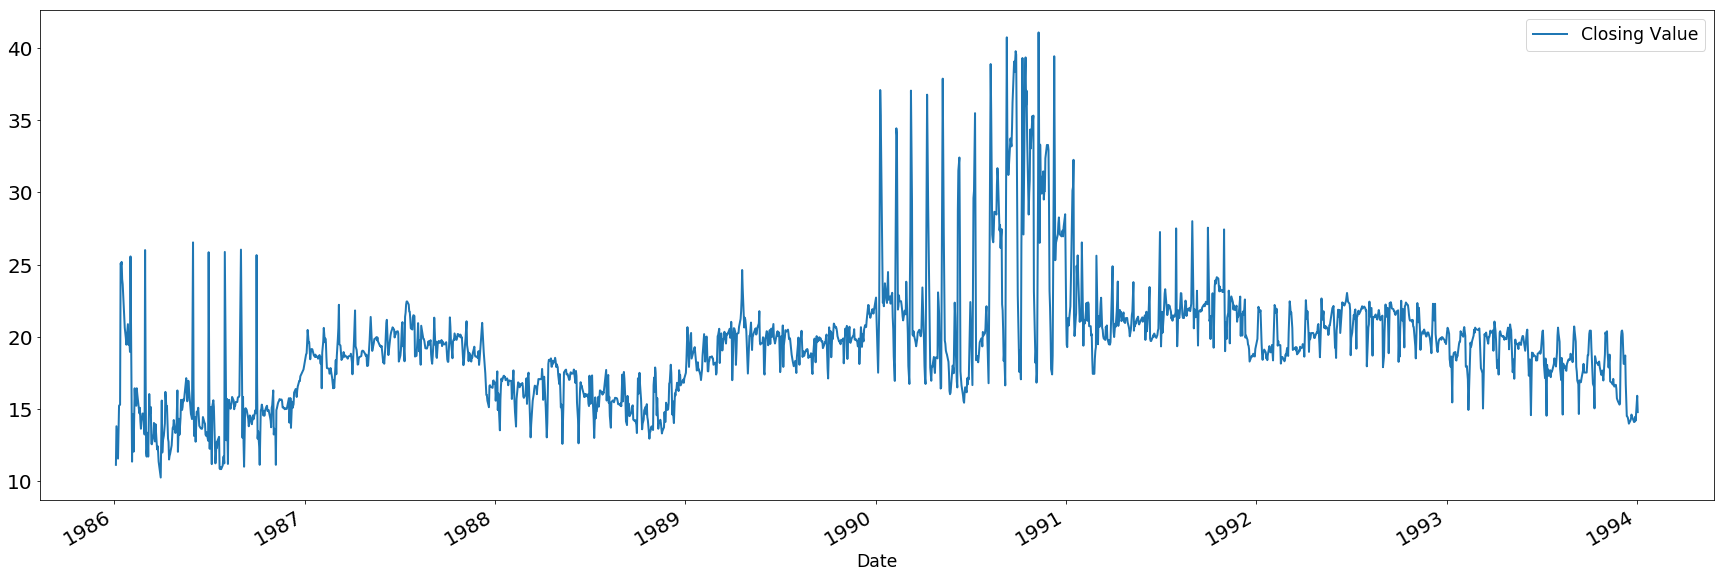

In [39]:
g1.plot(figsize=(30,10), linewidth=2, fontsize=20)

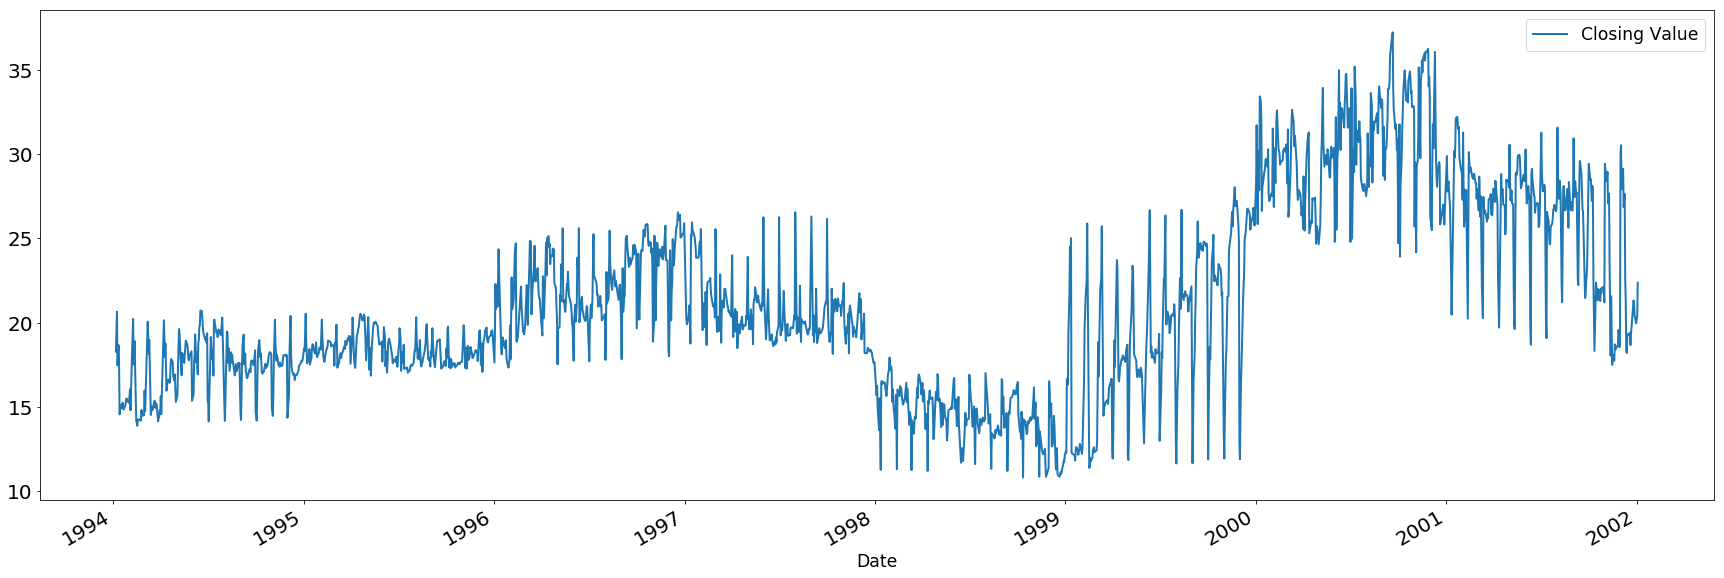

In [41]:
g2.plot(figsize=(30,10), linewidth=2, fontsize=20)

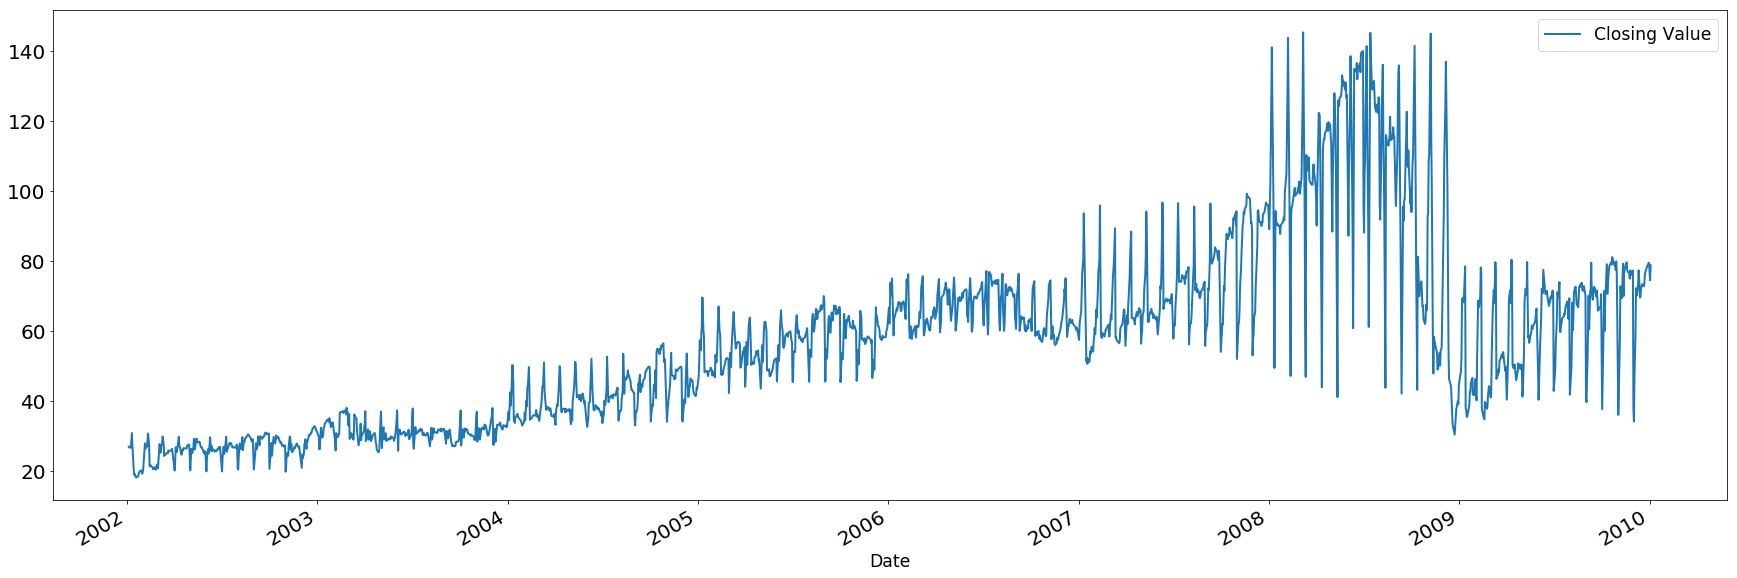

In [43]:
g3.plot(figsize=(30,10), linewidth=2, fontsize=20)

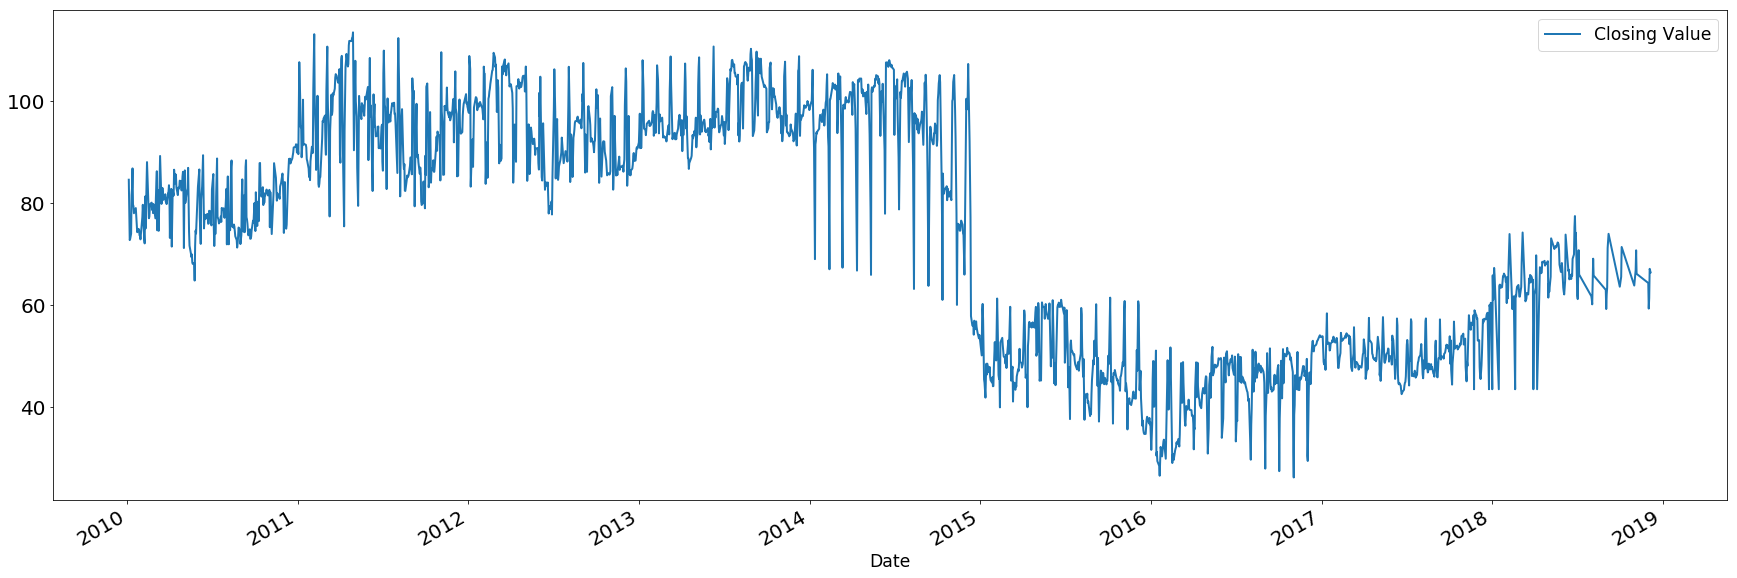

In [44]:
g4.plot(figsize=(30,10), linewidth=2, fontsize=20)

## Line graph visualization for the complete dataset

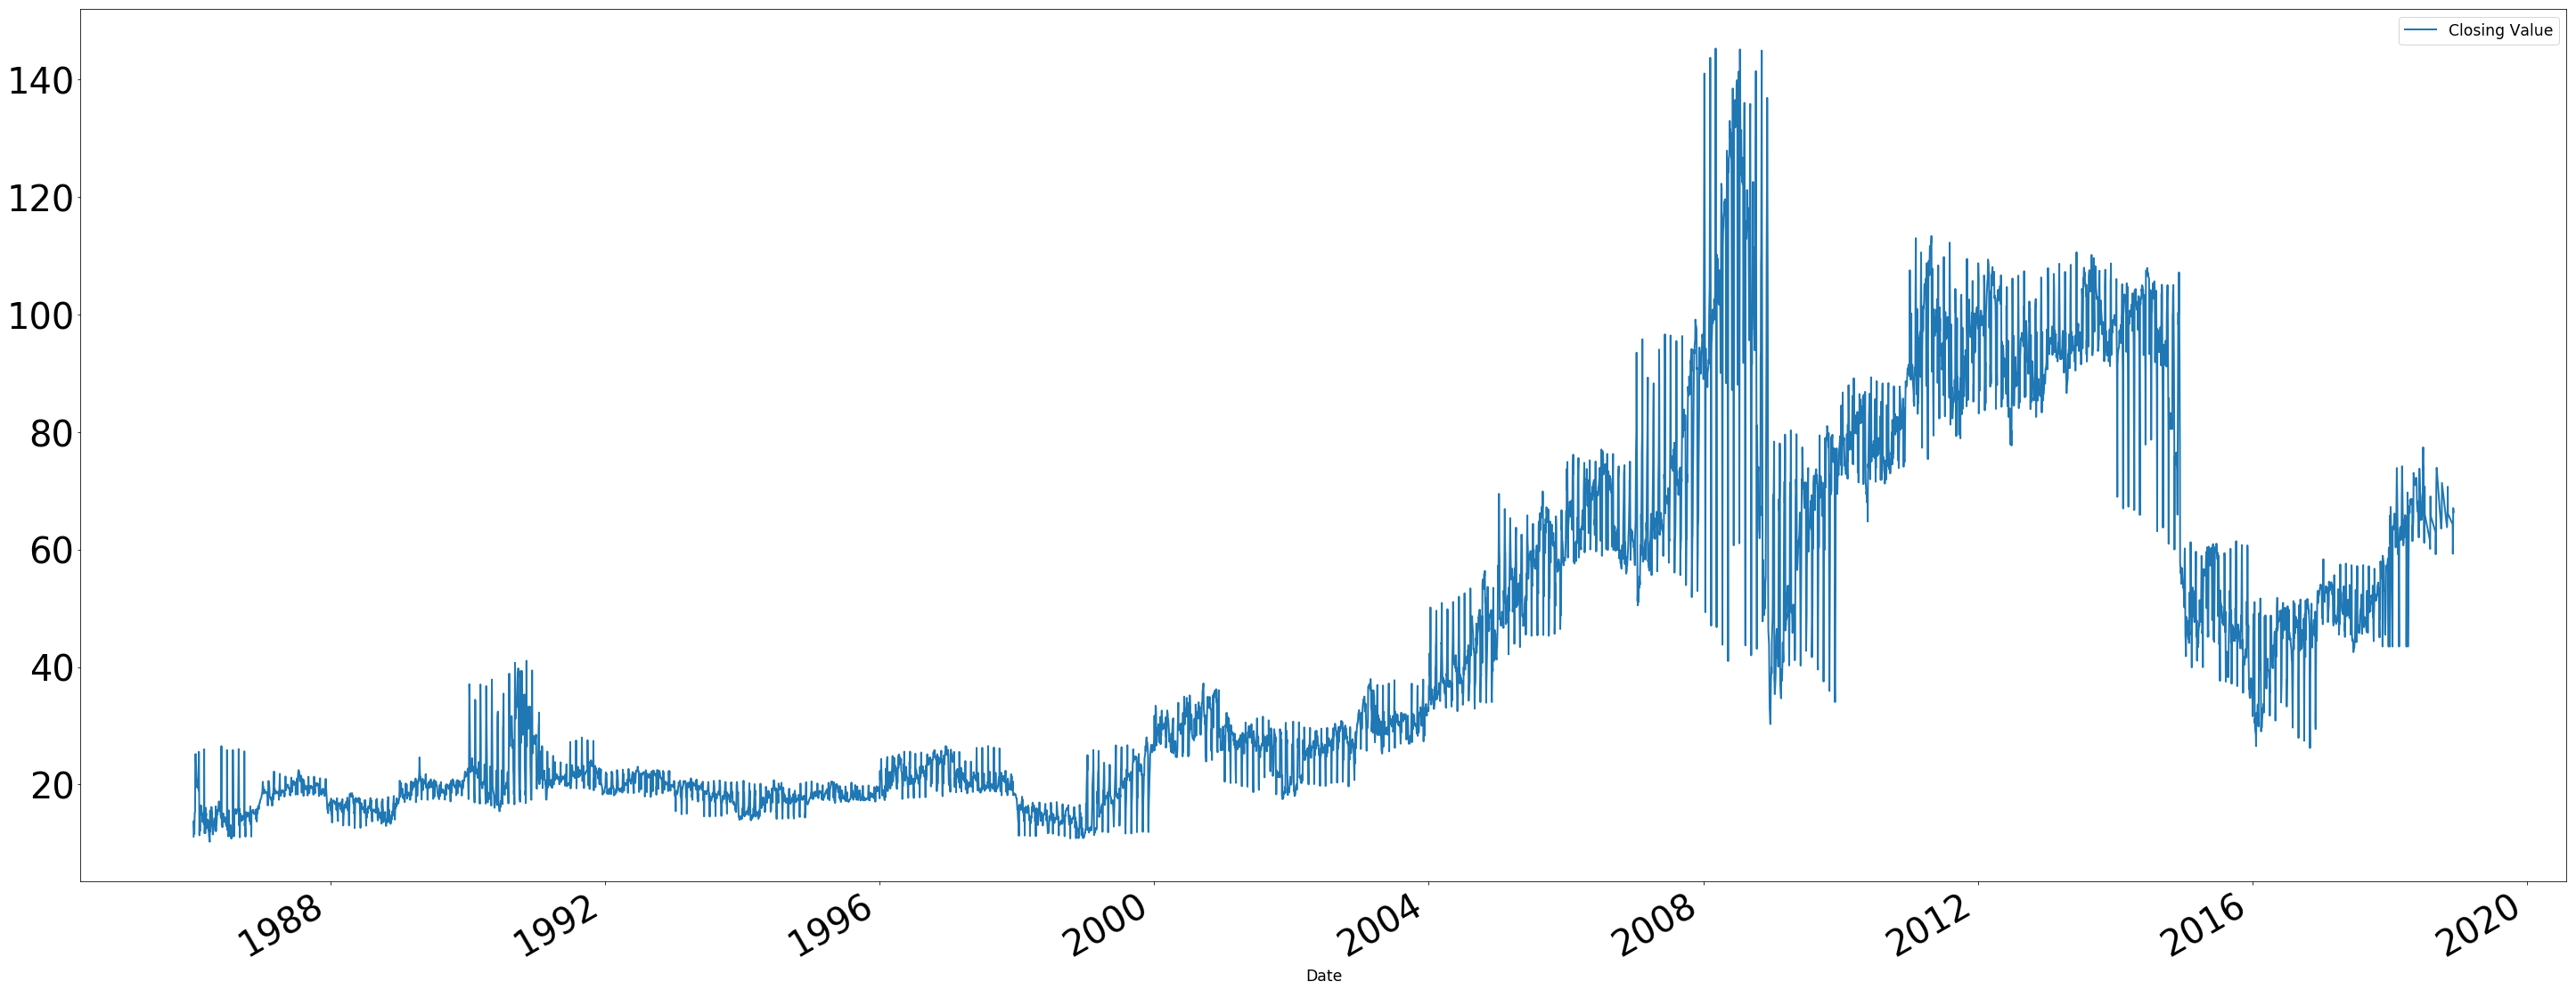

In [49]:
indexedDataset.plot(figsize=(50,20), linewidth=2, fontsize=40)

## Checking Stationarity of the data
#### The function test_stationary performs Rolling statistics and Dicky fuller test on the given time series

In [58]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    movingAverage = timeseries.rolling(window = 12).mean()
    movingStd = timeseries.rolling(window = 12).std()  
    
    #Plot rolling statistics
    orig = plt.plot(timeseries , color = 'blue' , label = 'Original')

    mean = plt.plot(movingAverage, color = 'red', label = 'Rolling Mean')
    std = plt.plot(movingStd , color = 'black', label = 'Rolling Std')

    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print("Results of Dicky fuller test")
    dftest = adfuller(timeseries['Closing Value'], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4] , index = ['Test Statistic', 'p-value' , '#Lags used', 'Number of Observations used'])

    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    
    print(dfoutput) 

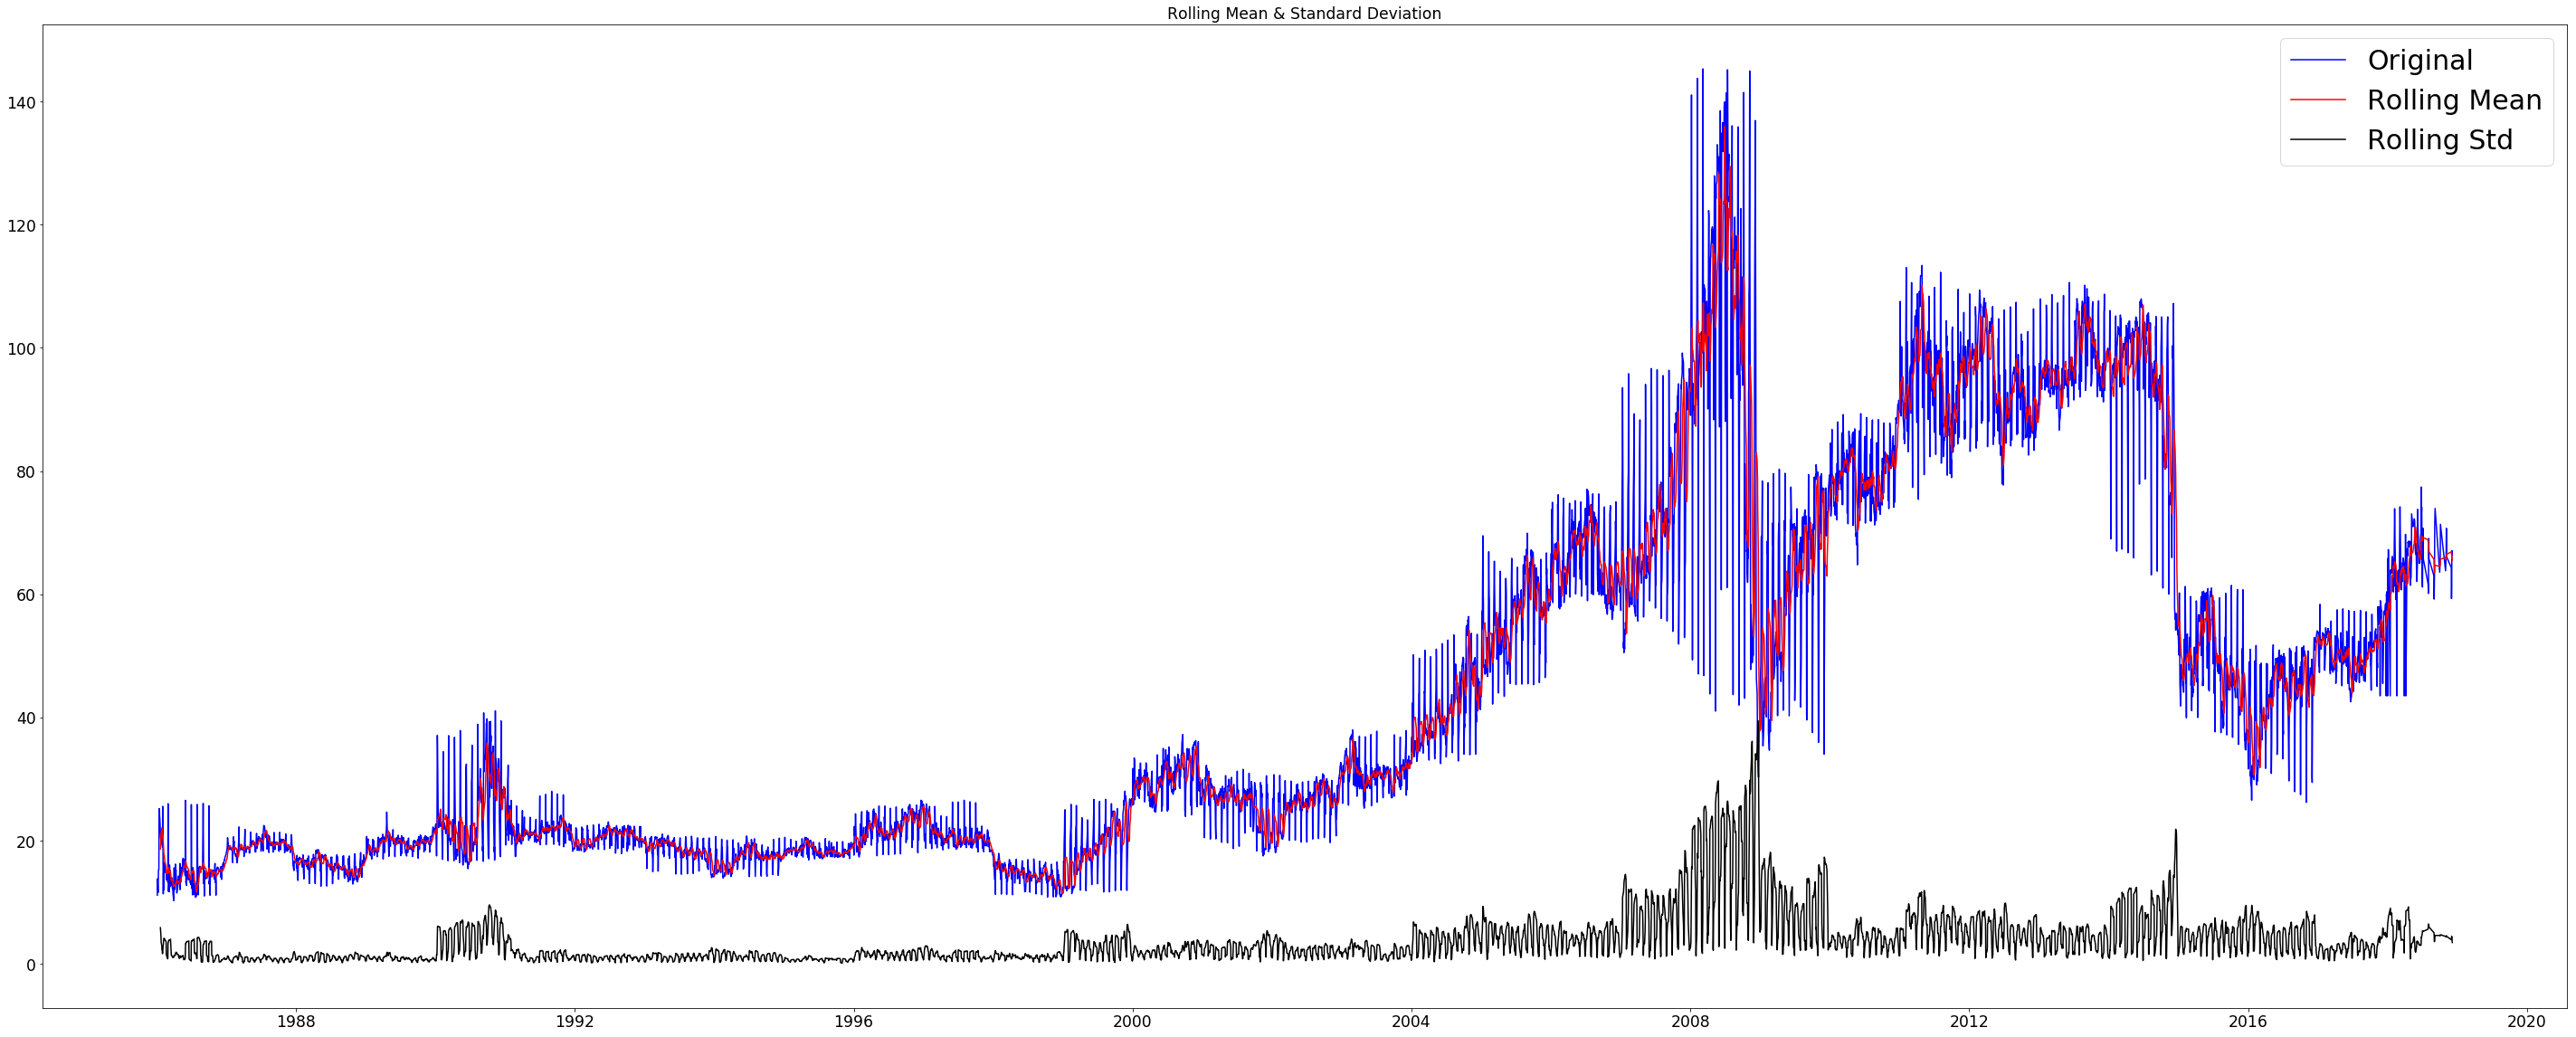

Results of Dicky fuller test
Test Statistic                   -1.643537
p-value                           0.460413
#Lags used                       37.000000
Number of Observations used    8185.000000
Critical value (1%)              -3.431149
Critical value (5%)              -2.861893
Critical value (10%)             -2.566958
dtype: float64


In [59]:
test_stationary(indexedDataset)

## For clear visualization of mean and standard deviation
##### Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic more than the critical values.

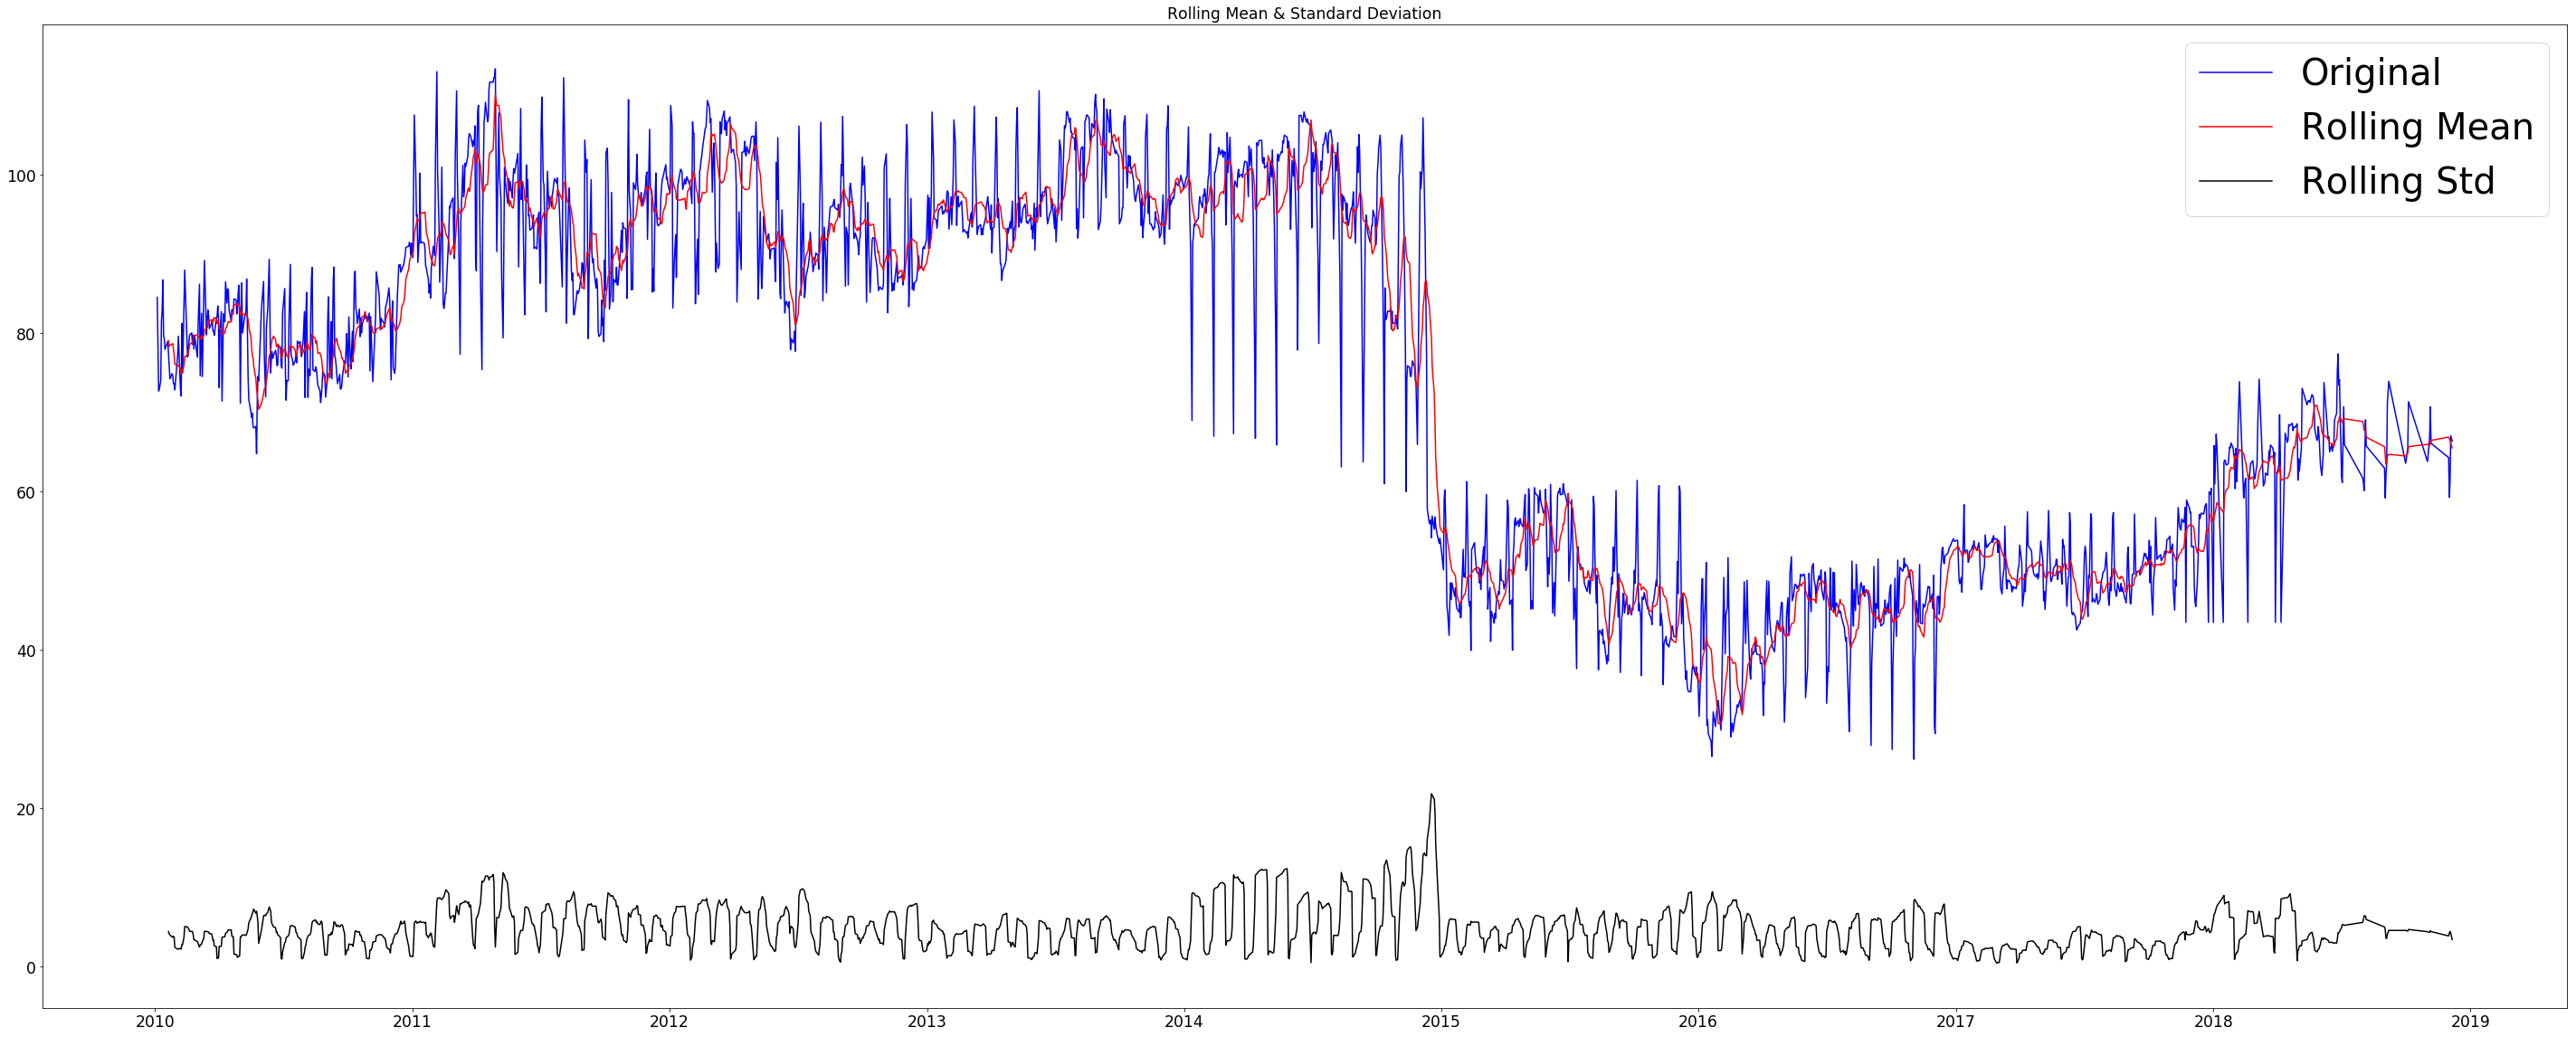

Results of Dicky fuller test
Test Statistic                   -1.036419
p-value                           0.739751
#Lags used                       24.000000
Number of Observations used    2140.000000
Critical value (1%)              -3.433409
Critical value (5%)              -2.862892
Critical value (10%)             -2.567489
dtype: float64


In [87]:
test_stationary(g4)

##### Now we try to make time series stationary

## Estimating and Eliminating Trend

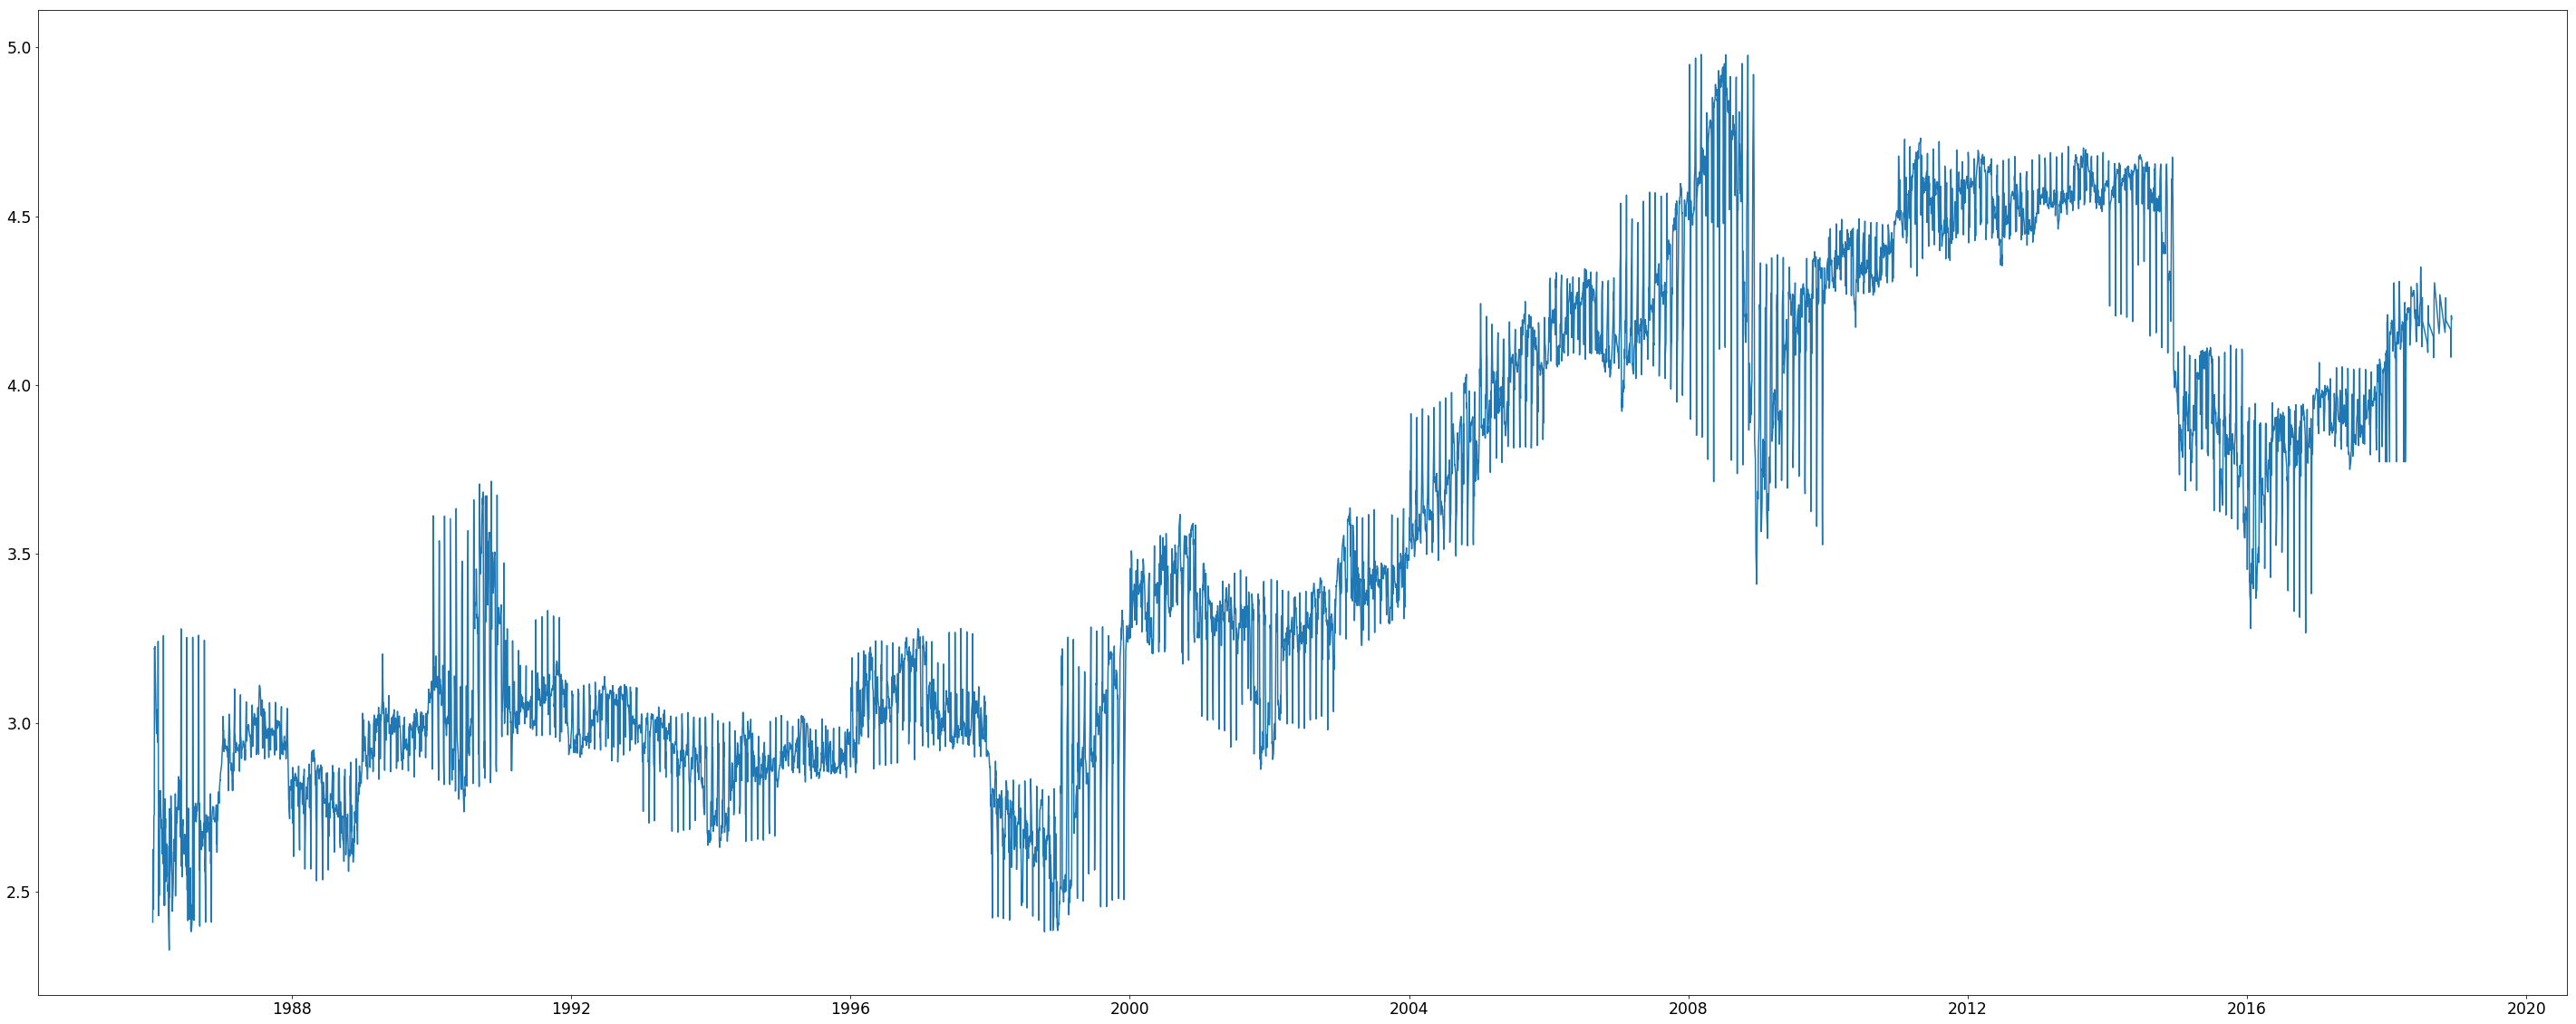

In [88]:
#Estimating trend
indexedDataset_logscale = np.log(indexedDataset)
plt.plot(indexedDataset_logscale)

## Moving Average
Here we can take the average over the past 1 year, i.e. last 12 values.

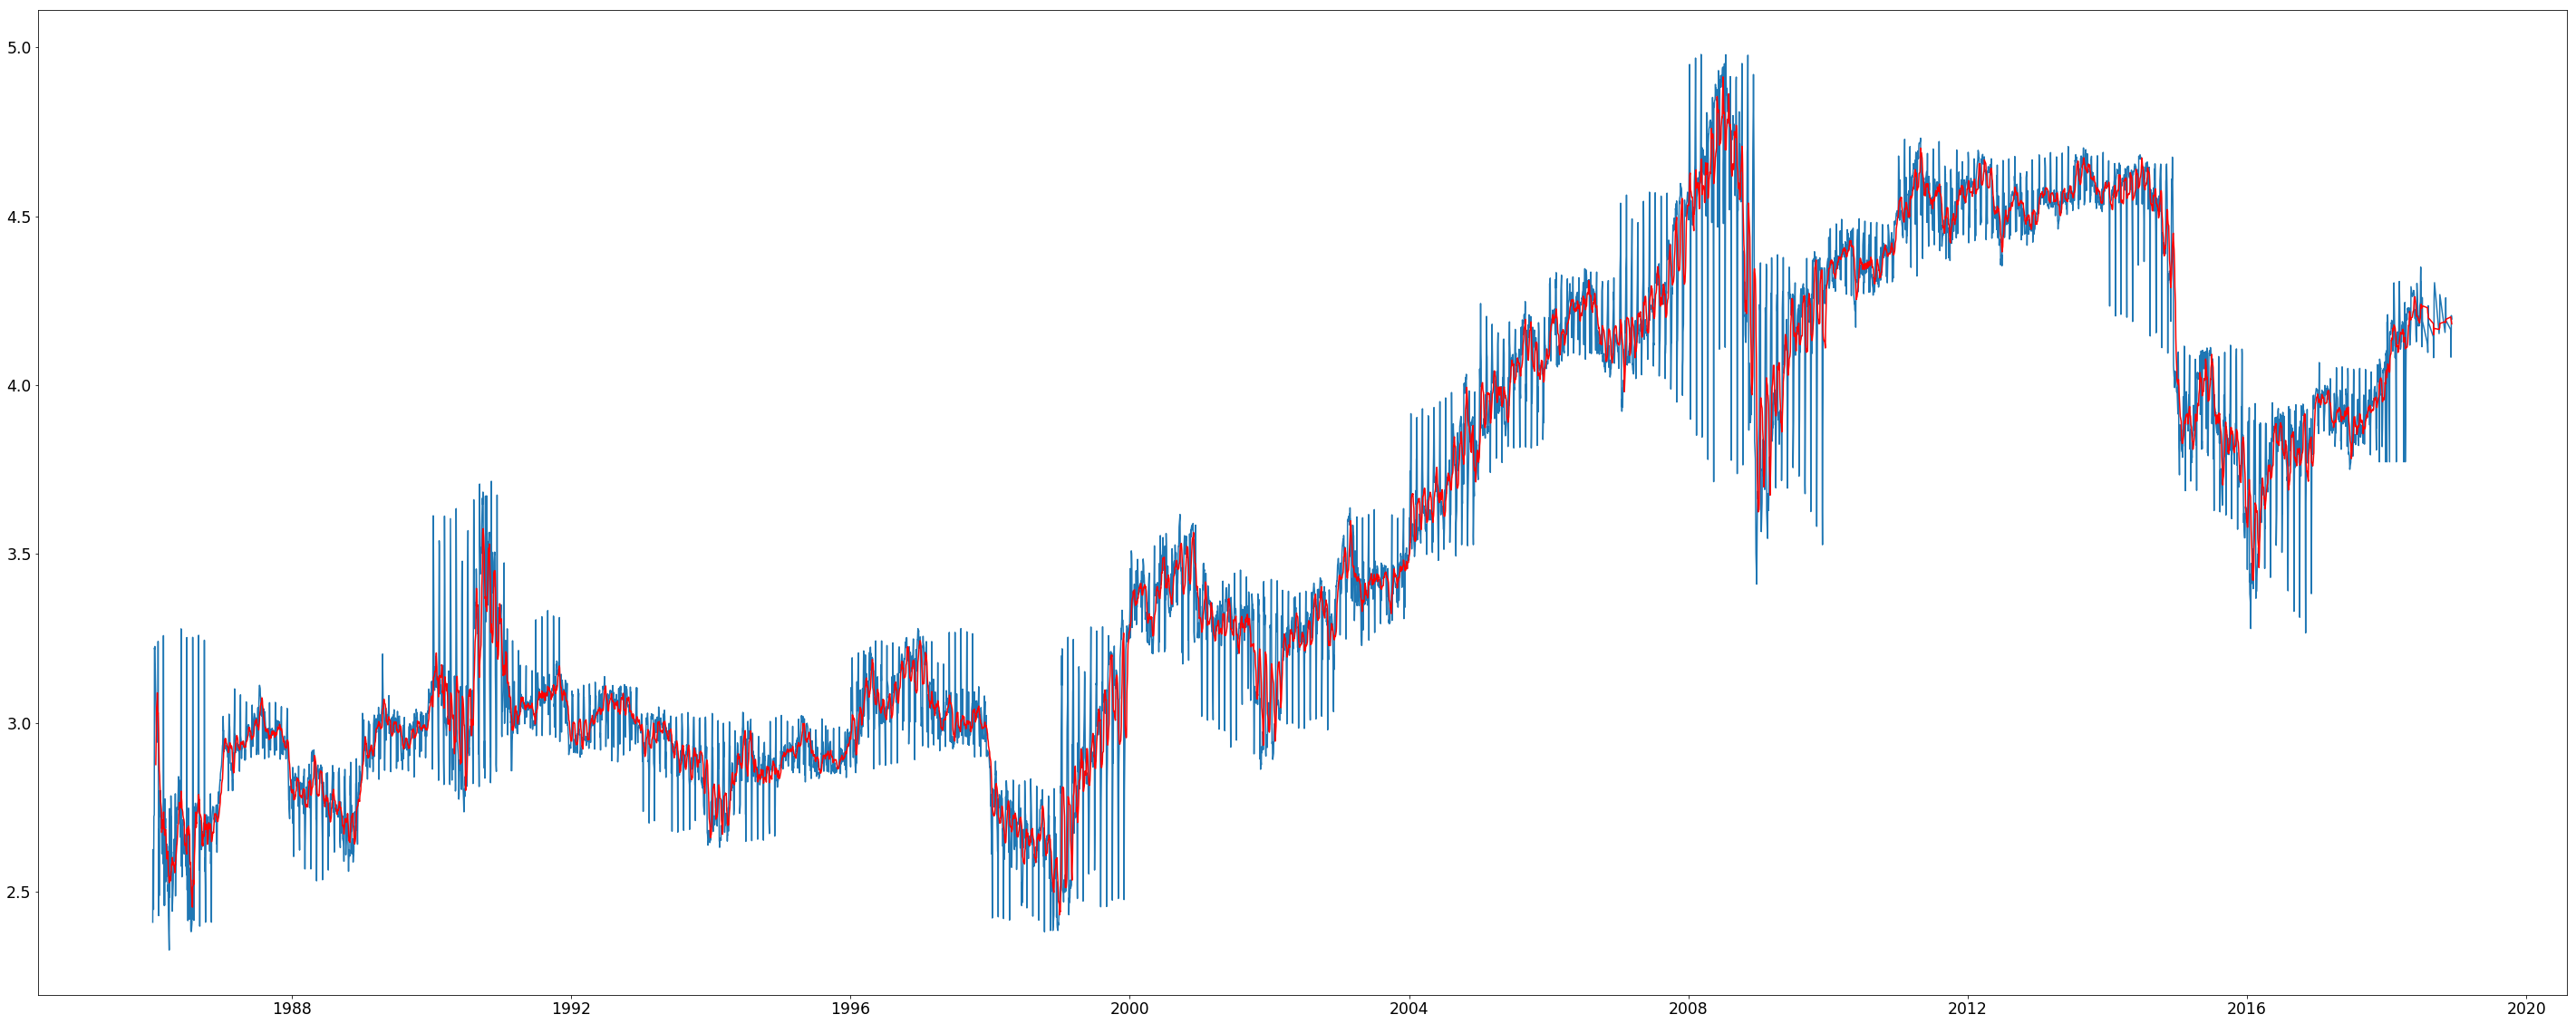

In [89]:
movingAverage = indexedDataset_logscale.rolling(window = 12).mean()

movingStd = indexedDataset_logscale.rolling(window = 12).std()  

plt.plot(indexedDataset_logscale)
plt.plot(movingAverage, color = 'red')

In [90]:
#diff between log scale and moving avg
difference = indexedDataset_logscale - movingAverage

#remove NaN values
difference.dropna(inplace = True)
difference.head(10)

Closing Value
Date                     
1986-01-20       0.183876
1986-01-21       0.098193
1986-01-22       0.048614
1986-01-23      -0.006926
1986-01-24      -0.074663
1986-01-27      -0.030451
1986-01-28      -0.120971
1986-01-29      -0.092275
1986-01-30      -0.073543
1986-01-31      -0.082560

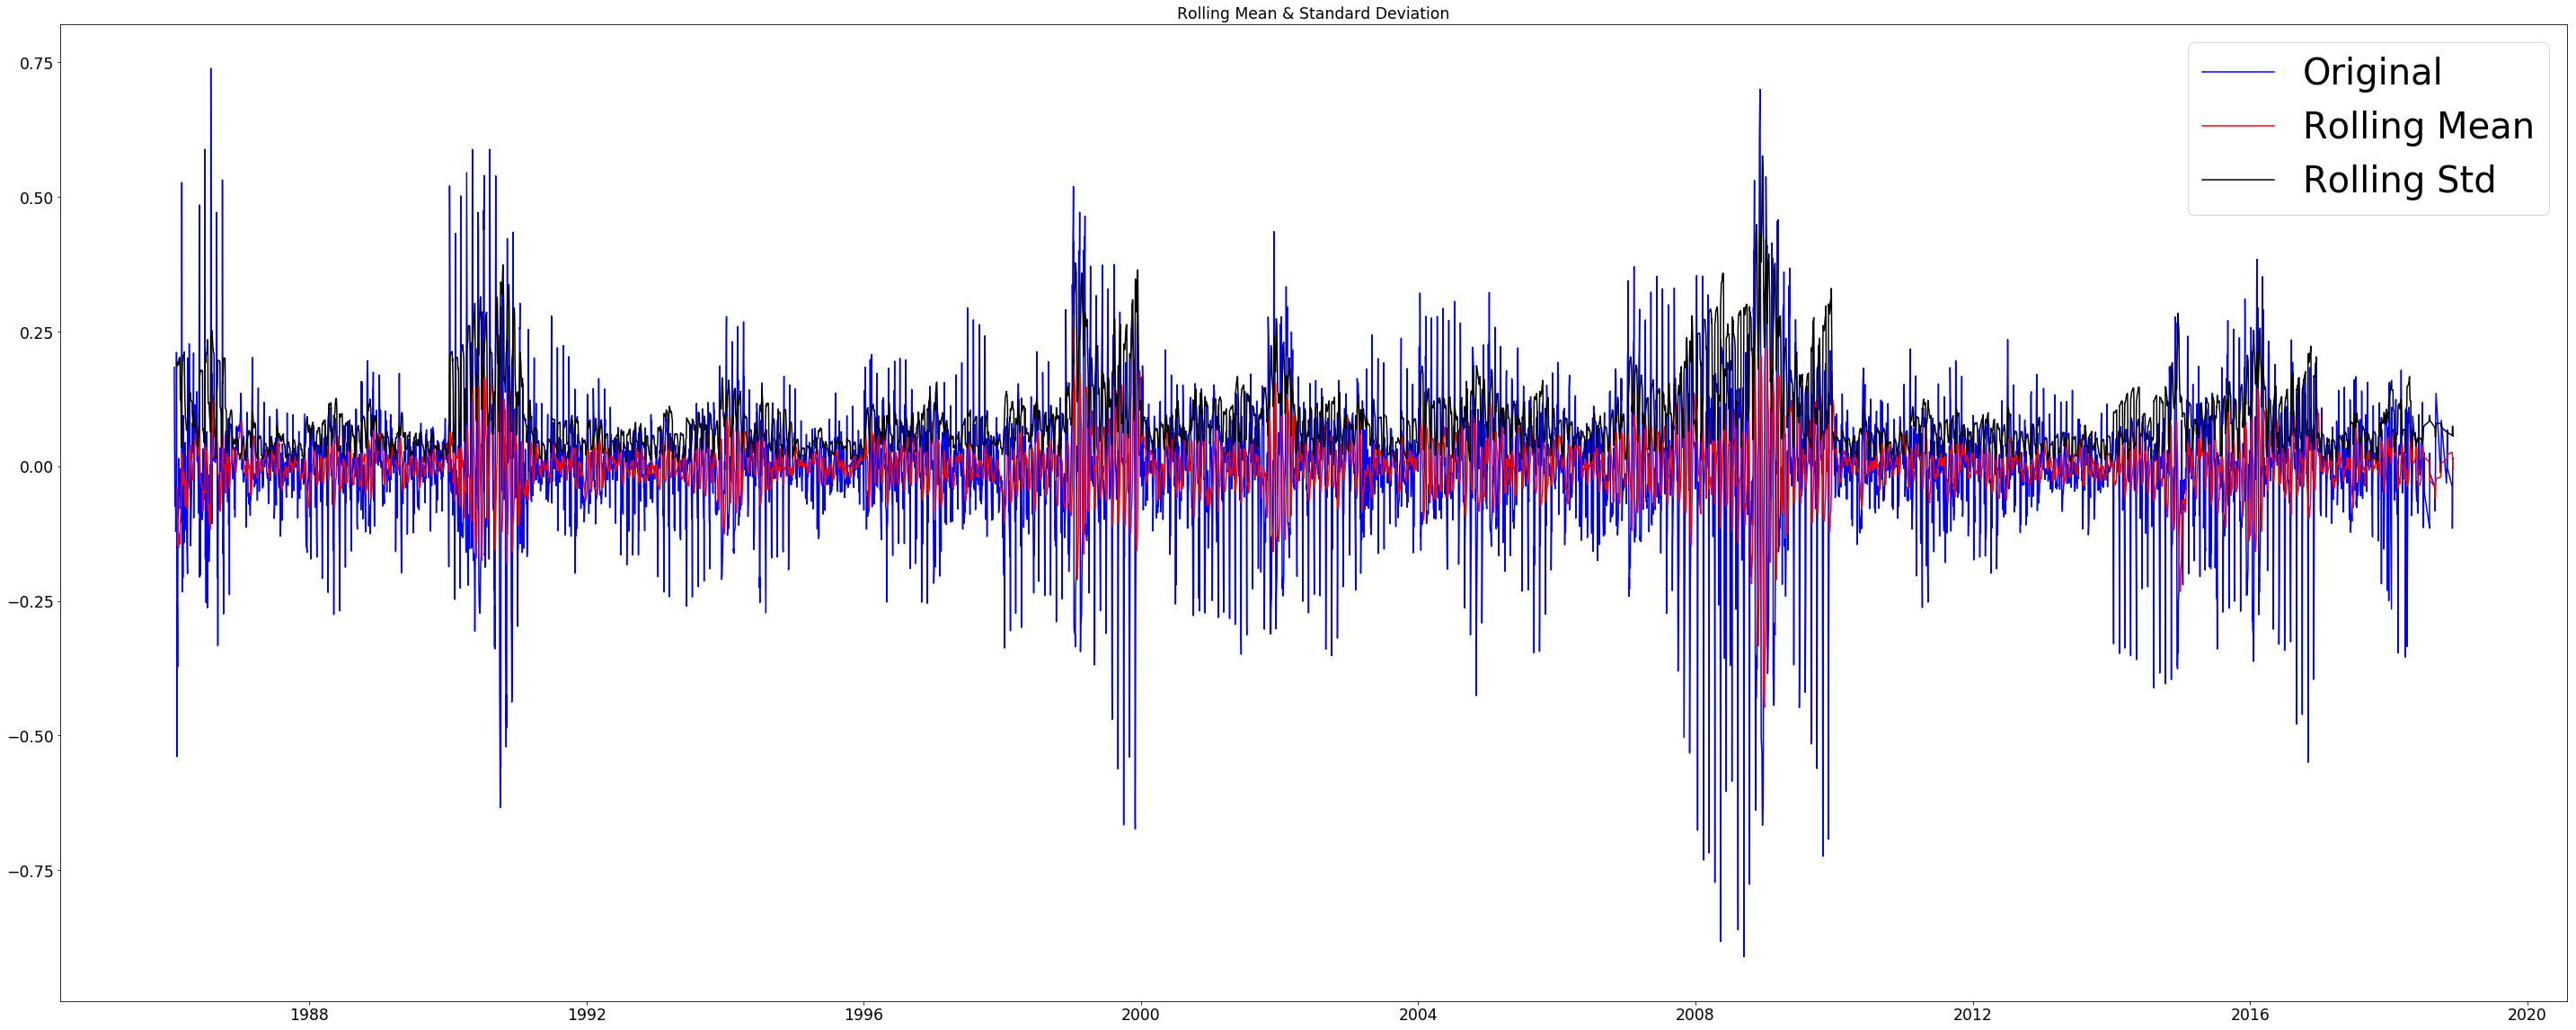

Results of Dicky fuller test
Test Statistic                -1.531479e+01
p-value                        4.139870e-28
#Lags used                     3.700000e+01
Number of Observations used    8.174000e+03
Critical value (1%)           -3.431150e+00
Critical value (5%)           -2.861894e+00
Critical value (10%)          -2.566958e+00
dtype: float64


In [91]:
test_stationary(difference)

## exponentially weighted moving average

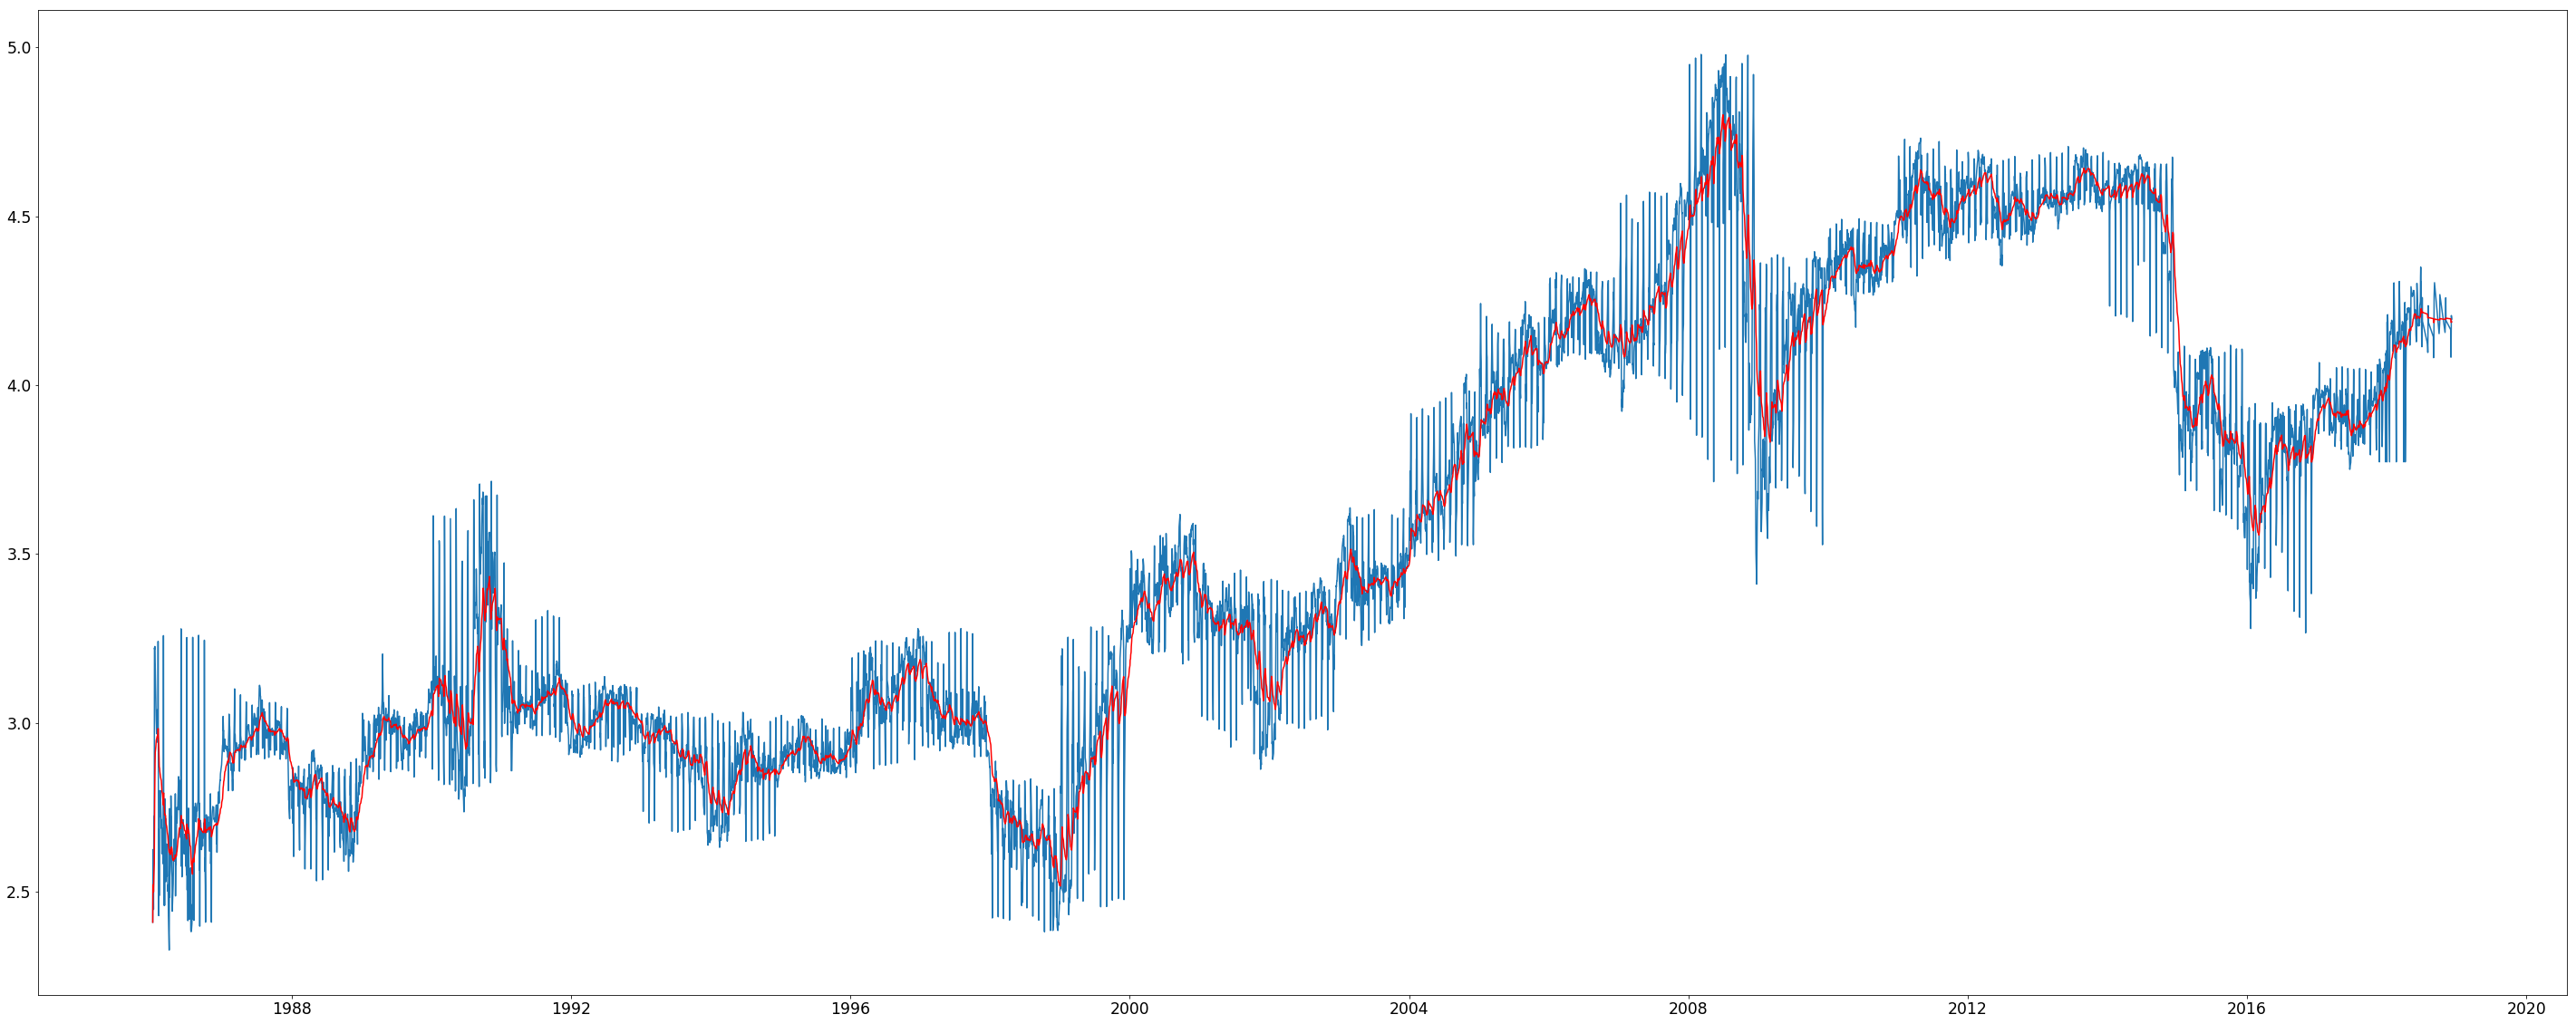

In [92]:
#exponential decay weighted average
EVA = indexedDataset_logscale.ewm(halflife = 12 , min_periods =0 , adjust= True).mean()
plt.plot(indexedDataset_logscale)
plt.plot(EVA, color ='red')

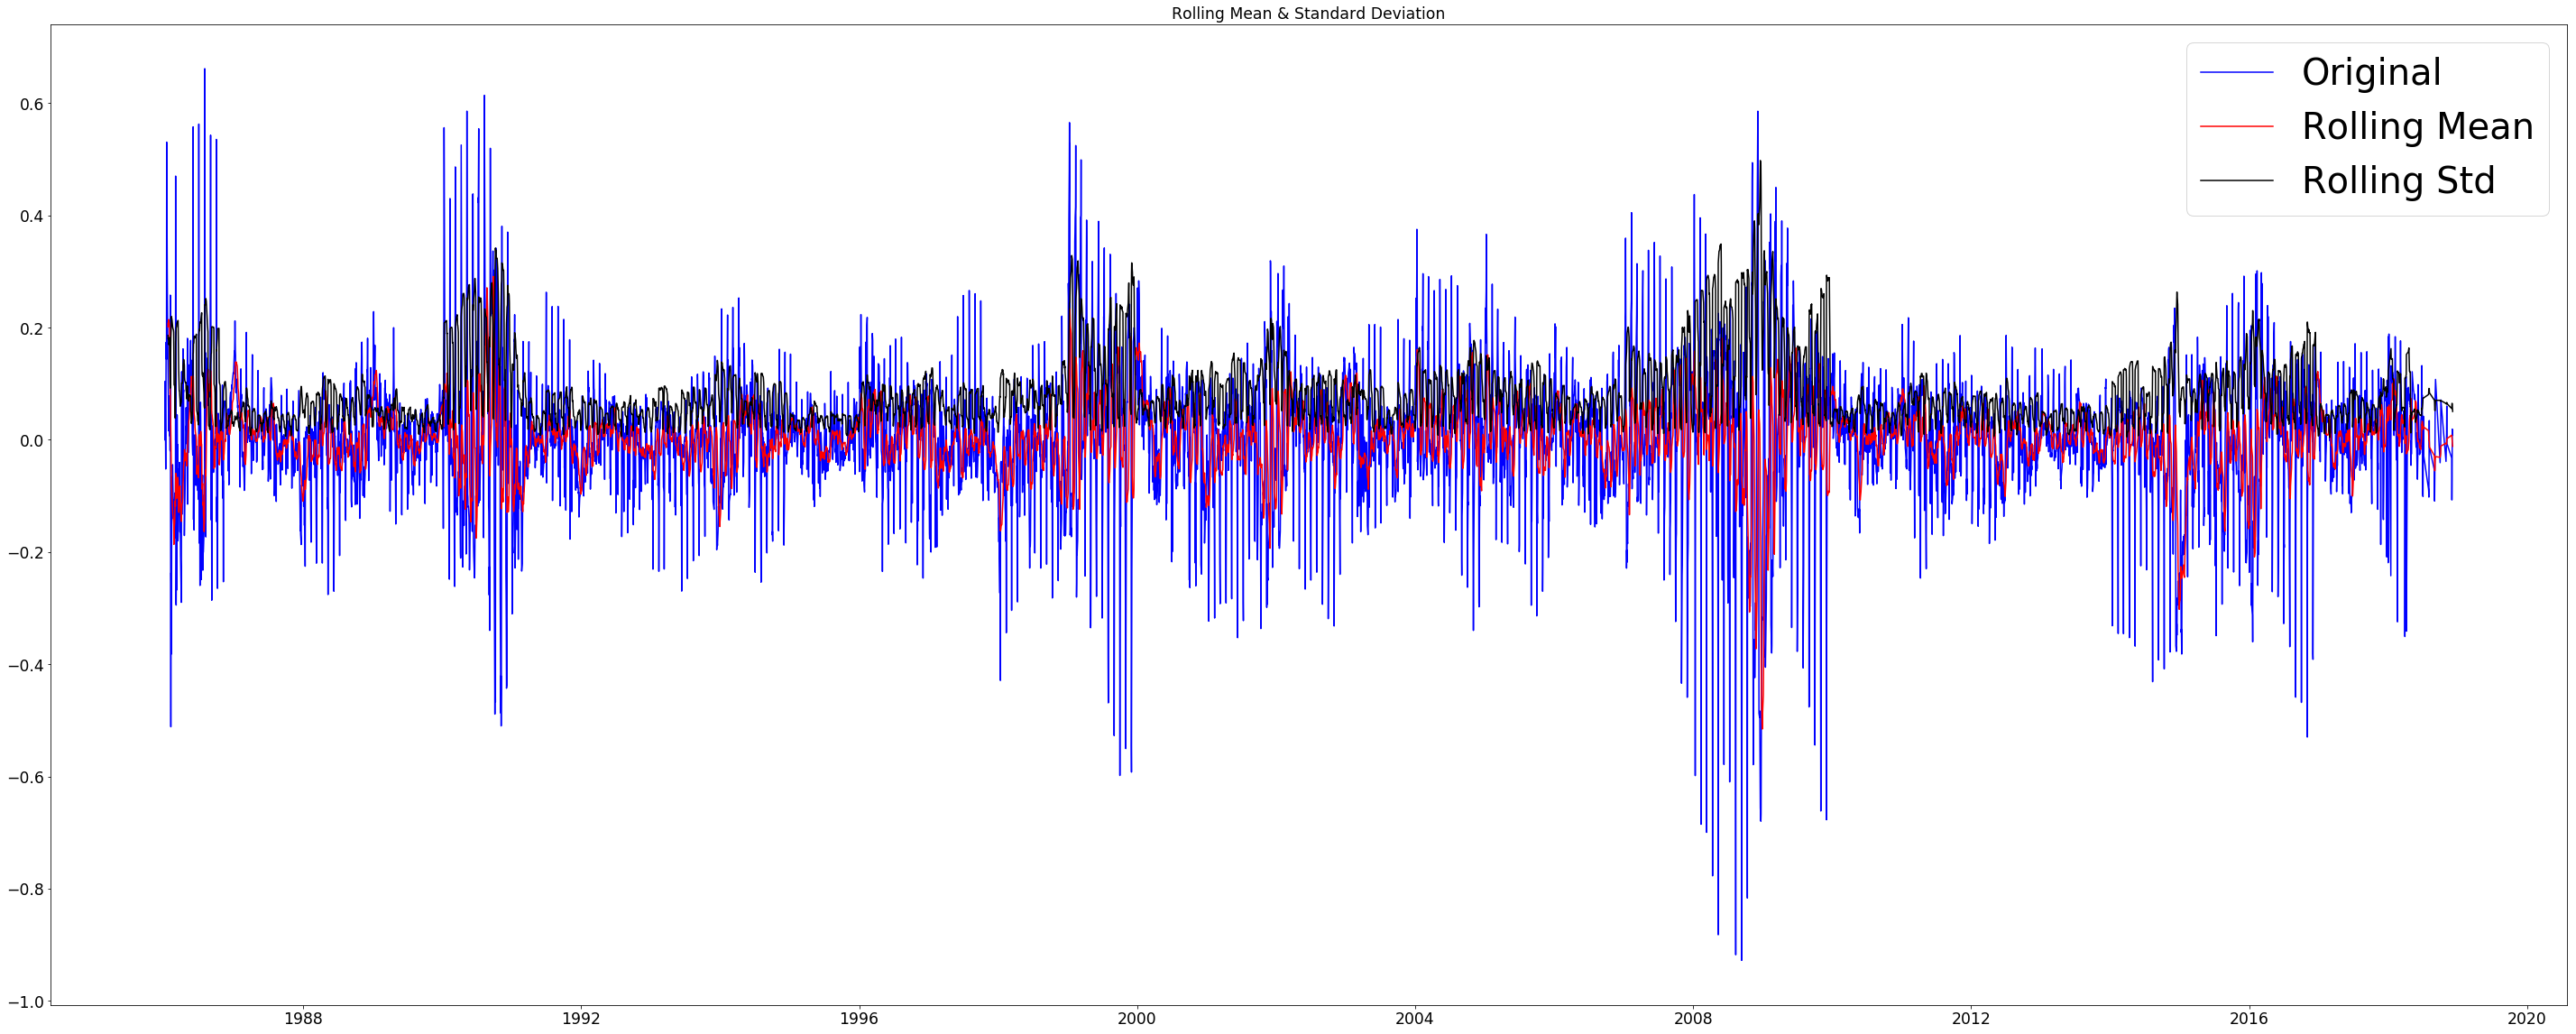

Results of Dicky fuller test
Test Statistic                -1.163640e+01
p-value                        2.199520e-21
#Lags used                     3.700000e+01
Number of Observations used    8.185000e+03
Critical value (1%)           -3.431149e+00
Critical value (5%)           -2.861893e+00
Critical value (10%)          -2.566958e+00
dtype: float64


In [93]:
# Logscale minus moving exponential
difference2 = indexedDataset_logscale - EVA
test_stationary(difference2)

## Eliminating Trend and Seasonality

### Differencing

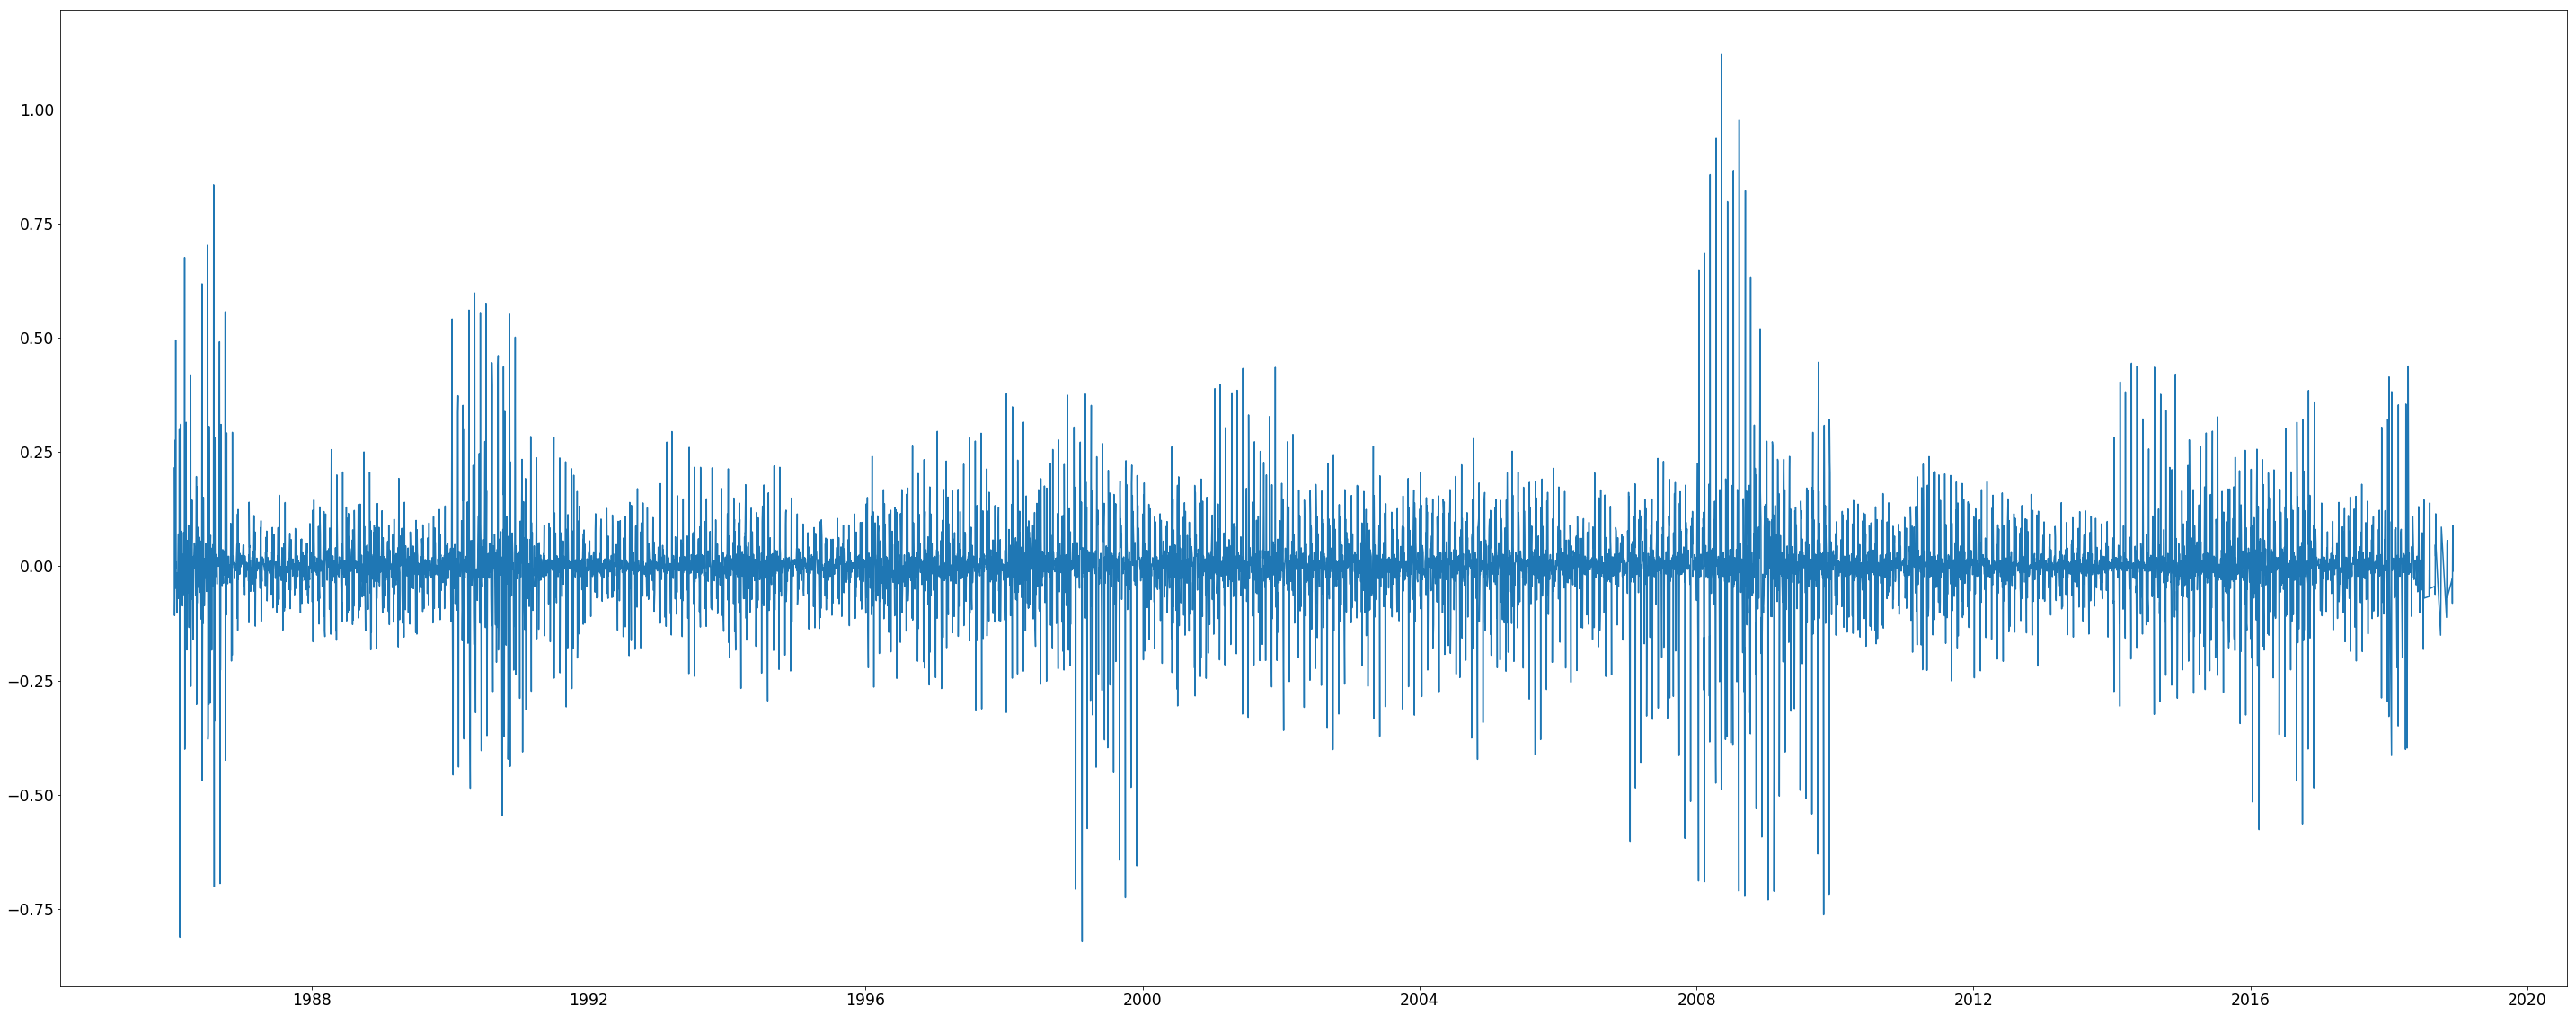

In [94]:
Log_shifting = indexedDataset_logscale - indexedDataset_logscale.shift()
plt.plot(Log_shifting)

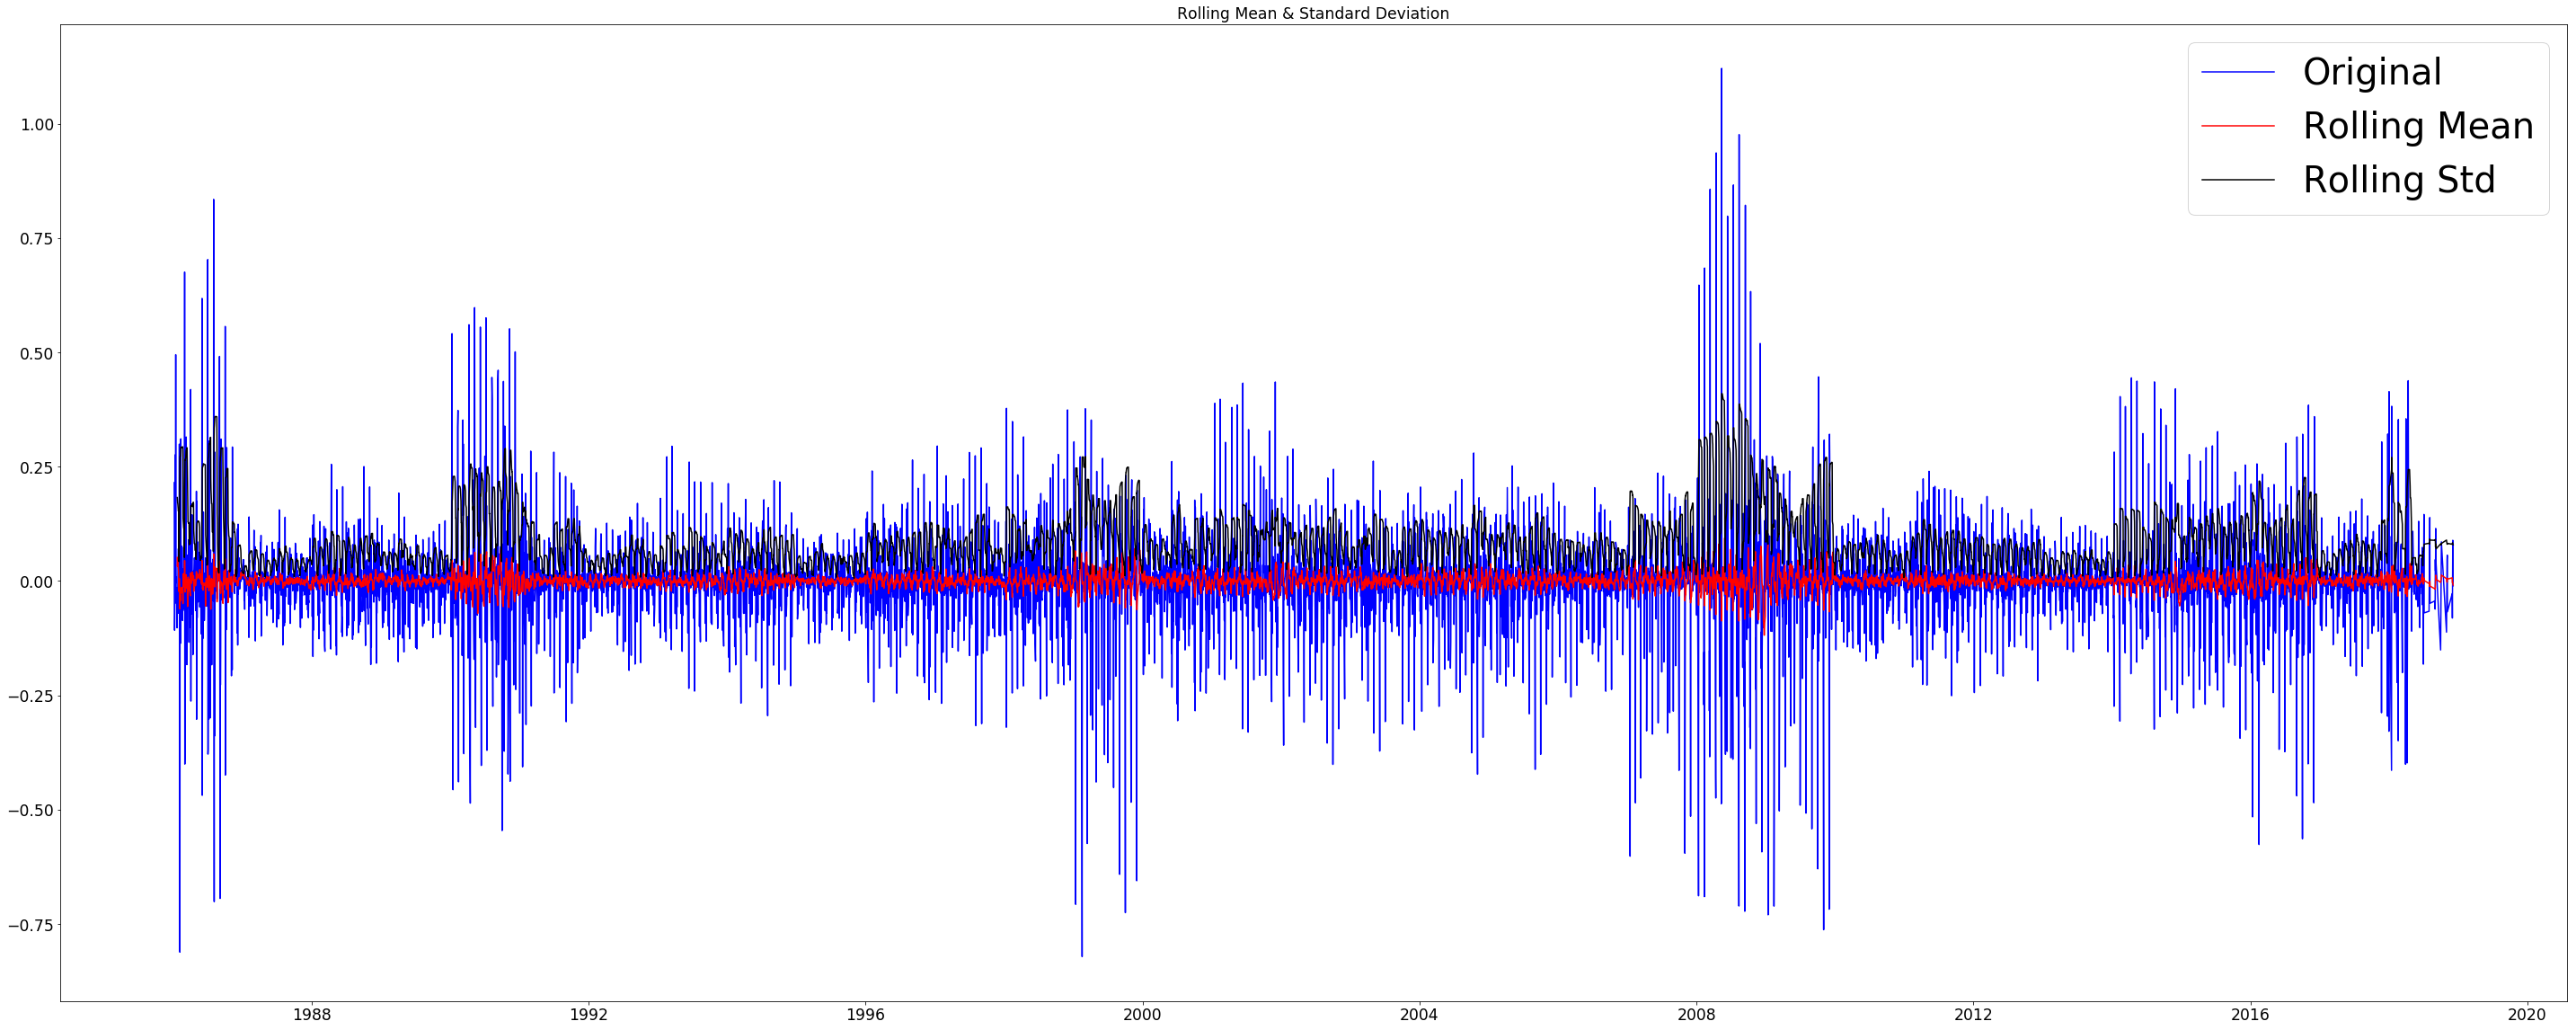

Results of Dicky fuller test
Test Statistic                -1.577386e+01
p-value                        1.152419e-28
#Lags used                     3.600000e+01
Number of Observations used    8.185000e+03
Critical value (1%)           -3.431149e+00
Critical value (5%)           -2.861893e+00
Critical value (10%)          -2.566958e+00
dtype: float64


In [95]:
Log_shifting.dropna(inplace = True)
test_stationary(Log_shifting)

## Decomposing

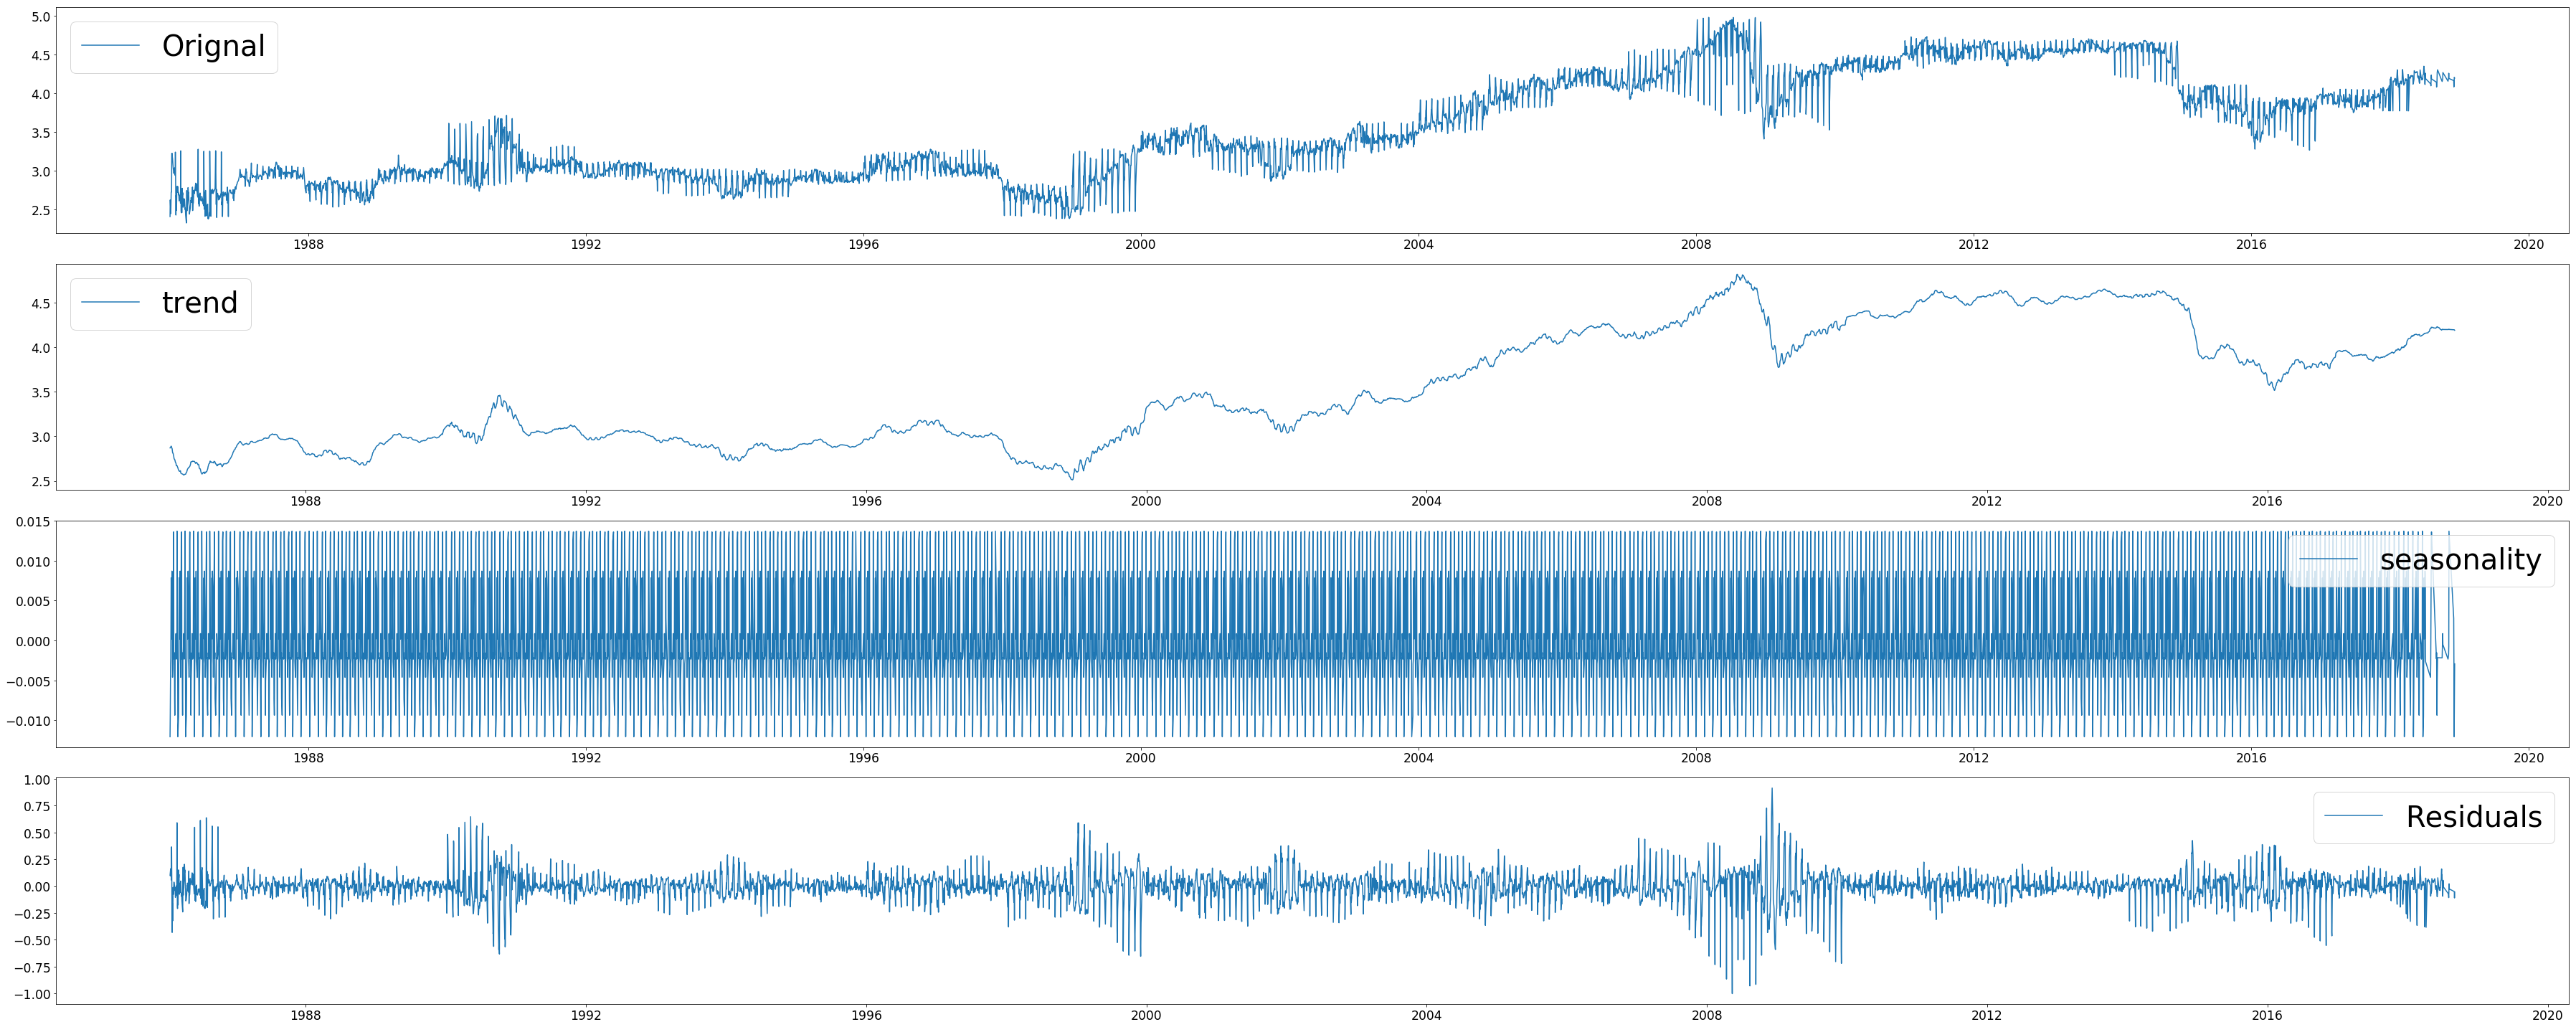

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logscale, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logscale , label = 'Orignal')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'trend')
plt.legend(loc ='best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonality')
plt.legend(loc ='best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc ='best')

plt.tight_layout()

##### Here we can see that the trend, seasonality are separated out from data and we can model the residuals

## Check stationarity of the Residuals

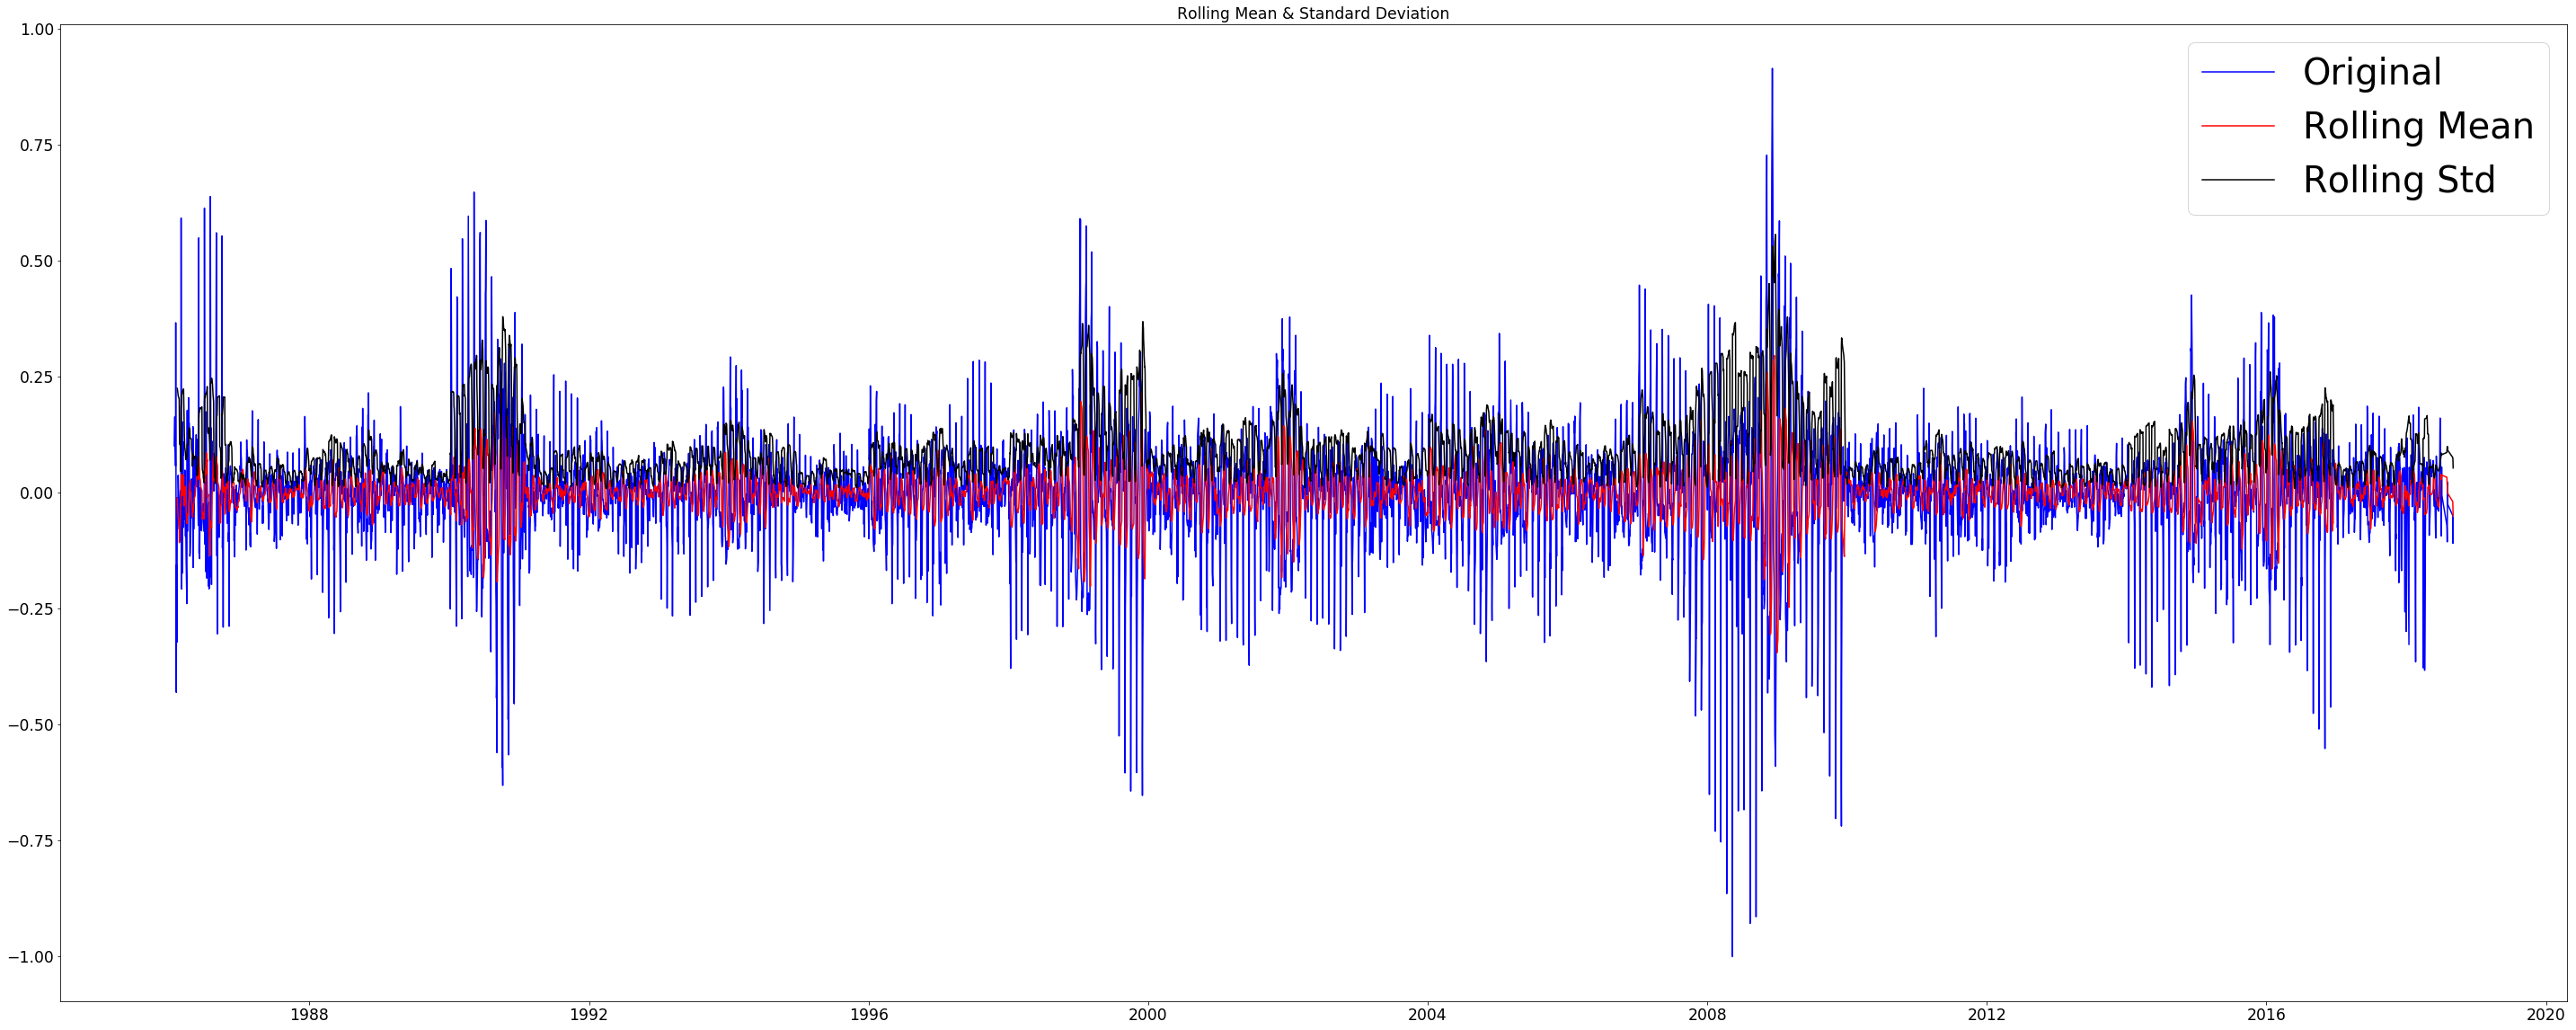

Results of Dicky fuller test
Test Statistic                  -23.788354
p-value                           0.000000
#Lags used                       37.000000
Number of Observations used    8155.000000
Critical value (1%)              -3.431152
Critical value (5%)              -2.861894
Critical value (10%)             -2.566959
dtype: float64


In [97]:
decomposedLogdata = residual
decomposedLogdata.dropna(inplace = True)
test_stationary(decomposedLogdata)

### The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

### ACF and PACF Plots

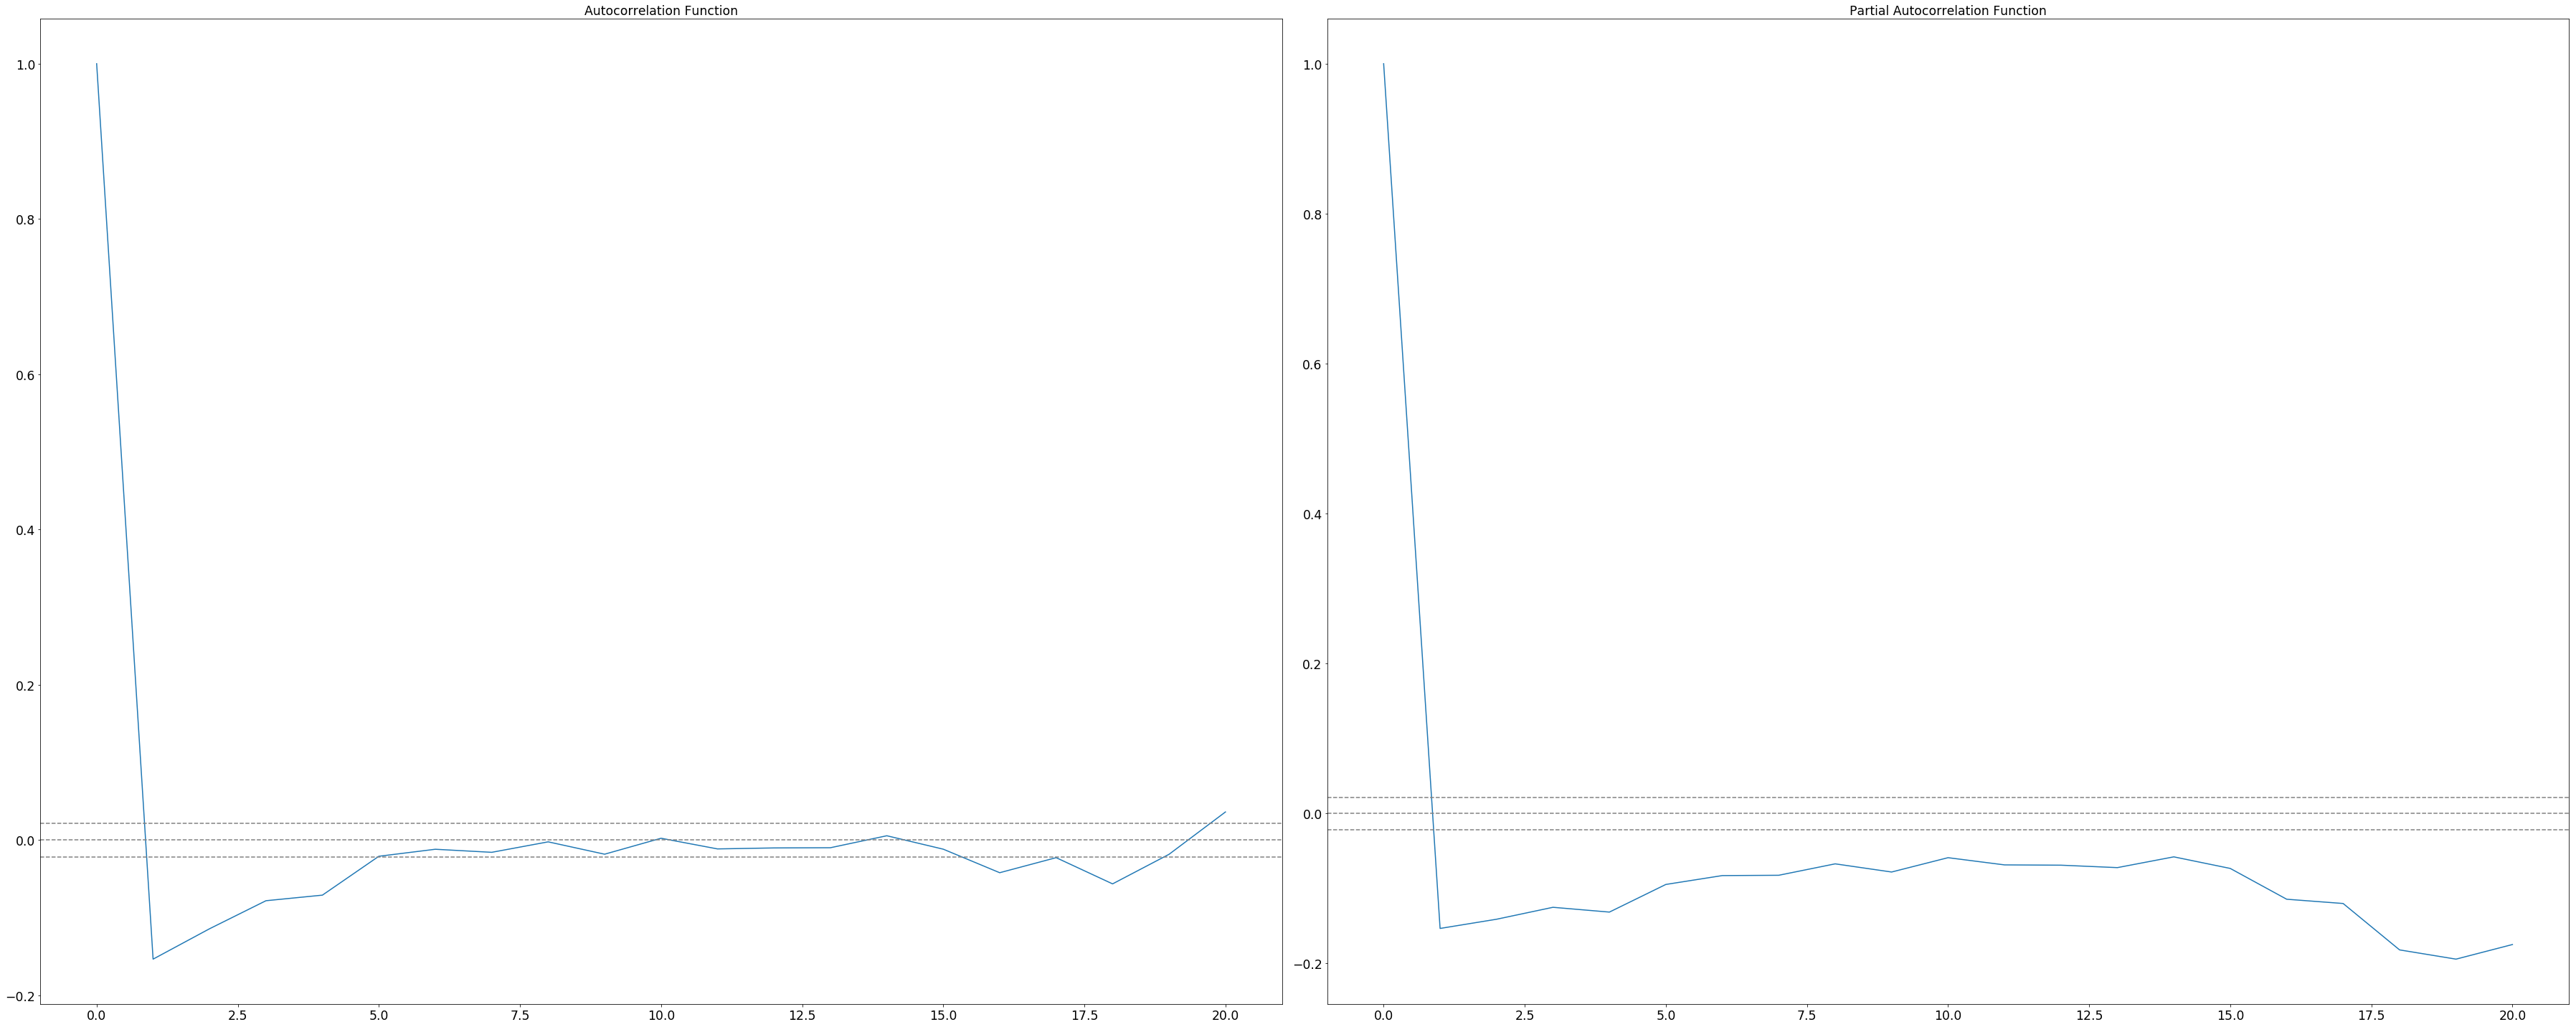

In [98]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(Log_shifting, nlags=20)
lag_pacf = pacf(Log_shifting, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Log_shifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Log_shifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Log_shifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Log_shifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#### p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
#### q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

In [99]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 73.8852')

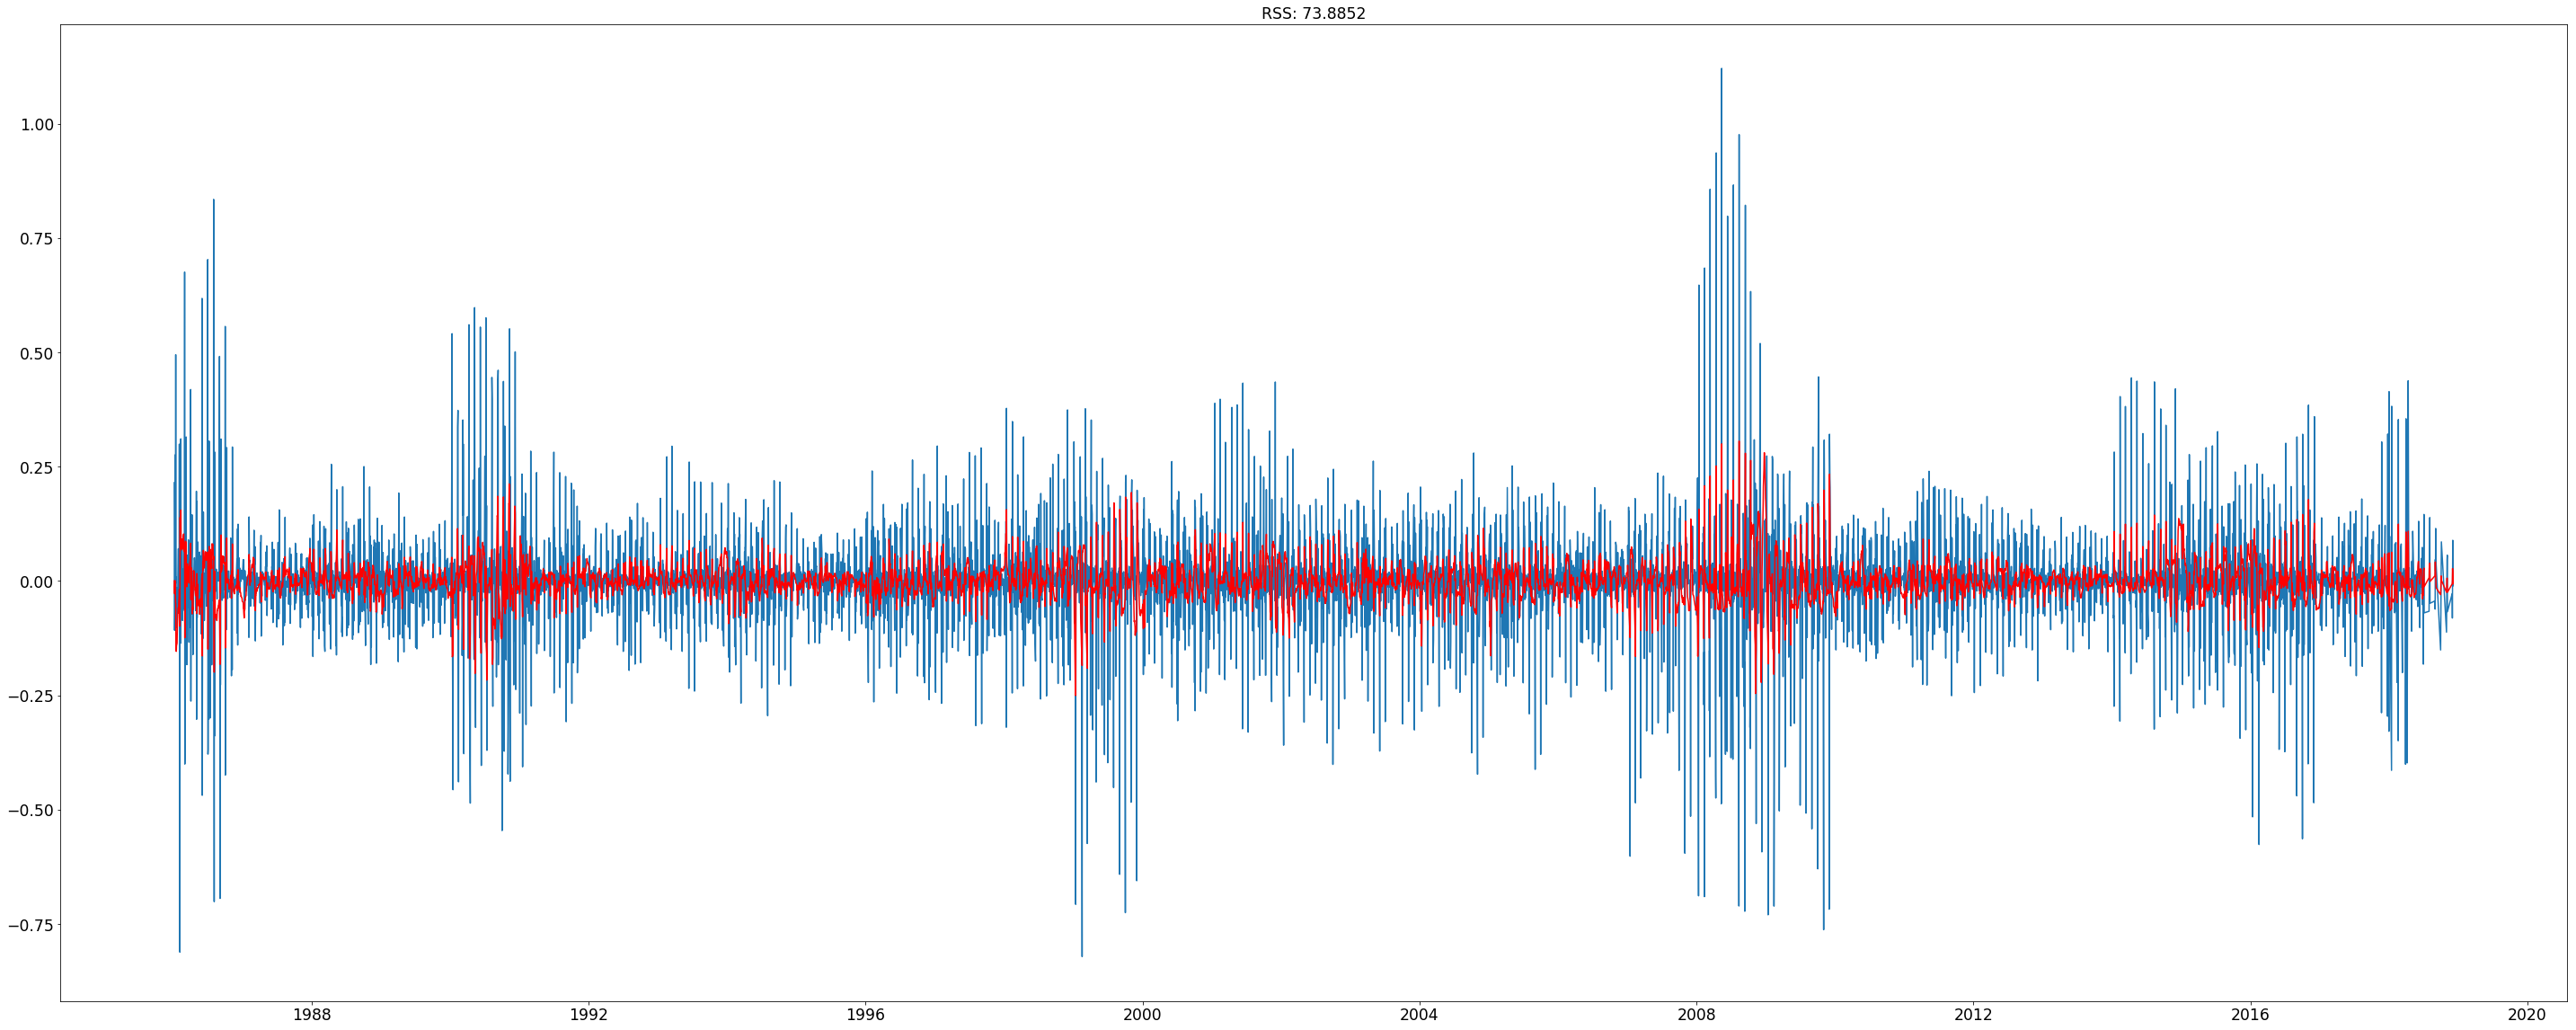

In [108]:
model = ARIMA(indexedDataset_logscale, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(Log_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues- Log_shifting['Closing Value'])**2))

##### store the predicted results as a separate series and observe it

In [109]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1986-01-05    0.000158
1986-01-07   -0.027856
1986-01-08   -0.011530
1986-01-10    0.000501
1986-01-12   -0.047833
dtype: float64


In [110]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
1986-01-05    0.000158
1986-01-07   -0.027698
1986-01-08   -0.039227
1986-01-10   -0.038726
1986-01-12   -0.086559
dtype: float64


In [111]:
predictions_ARIMA_log = pd.Series(indexedDataset_logscale['Closing Value'].ix[0], index=indexedDataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
1986-01-04    2.409644
1986-01-05    2.409803
1986-01-07    2.381947
1986-01-08    2.370417
1986-01-10    2.370918
dtype: float64

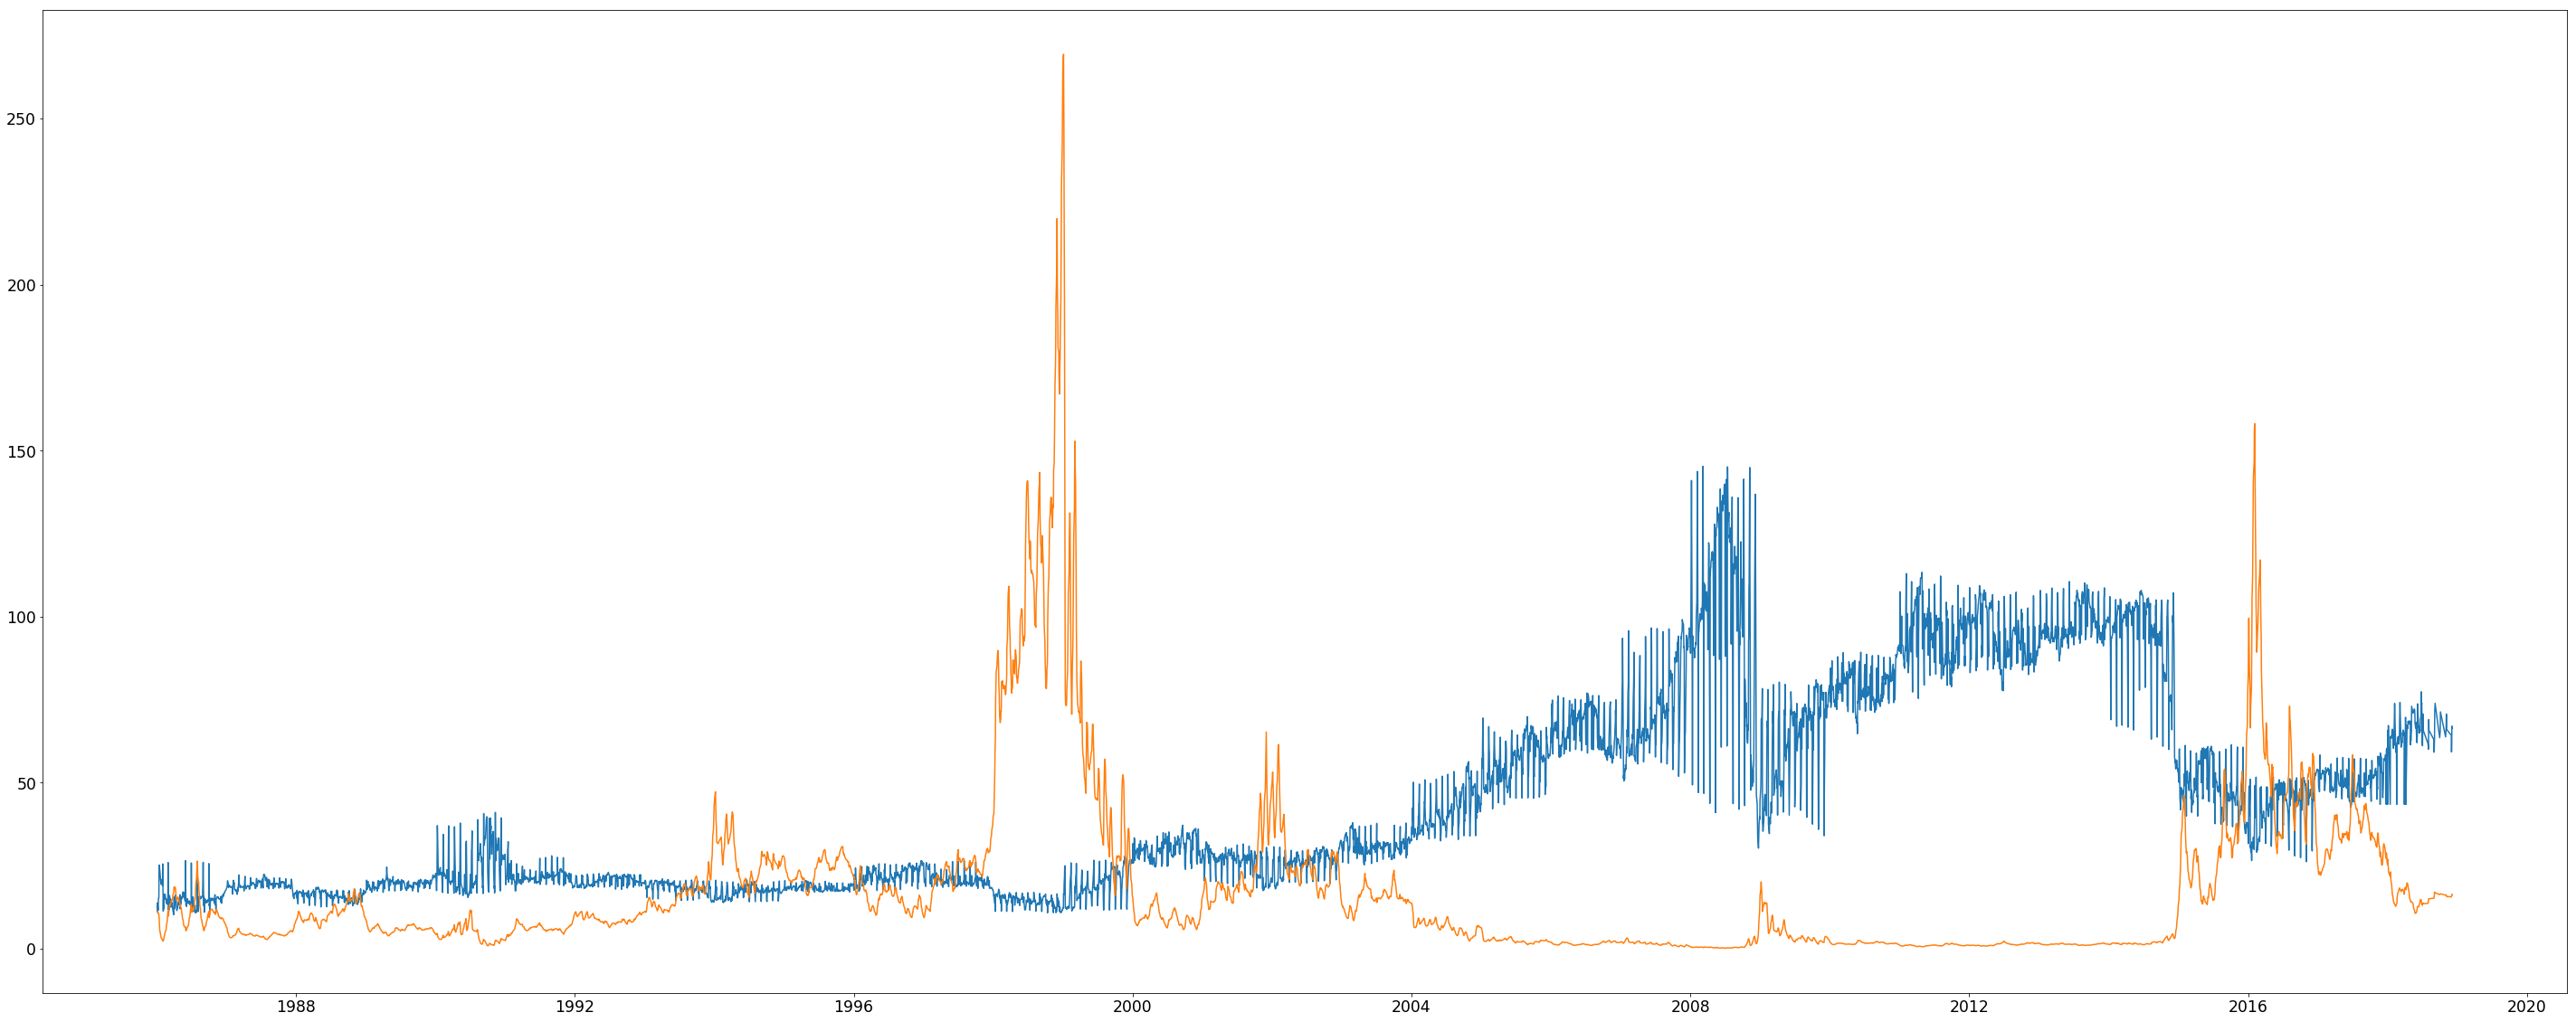

In [112]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


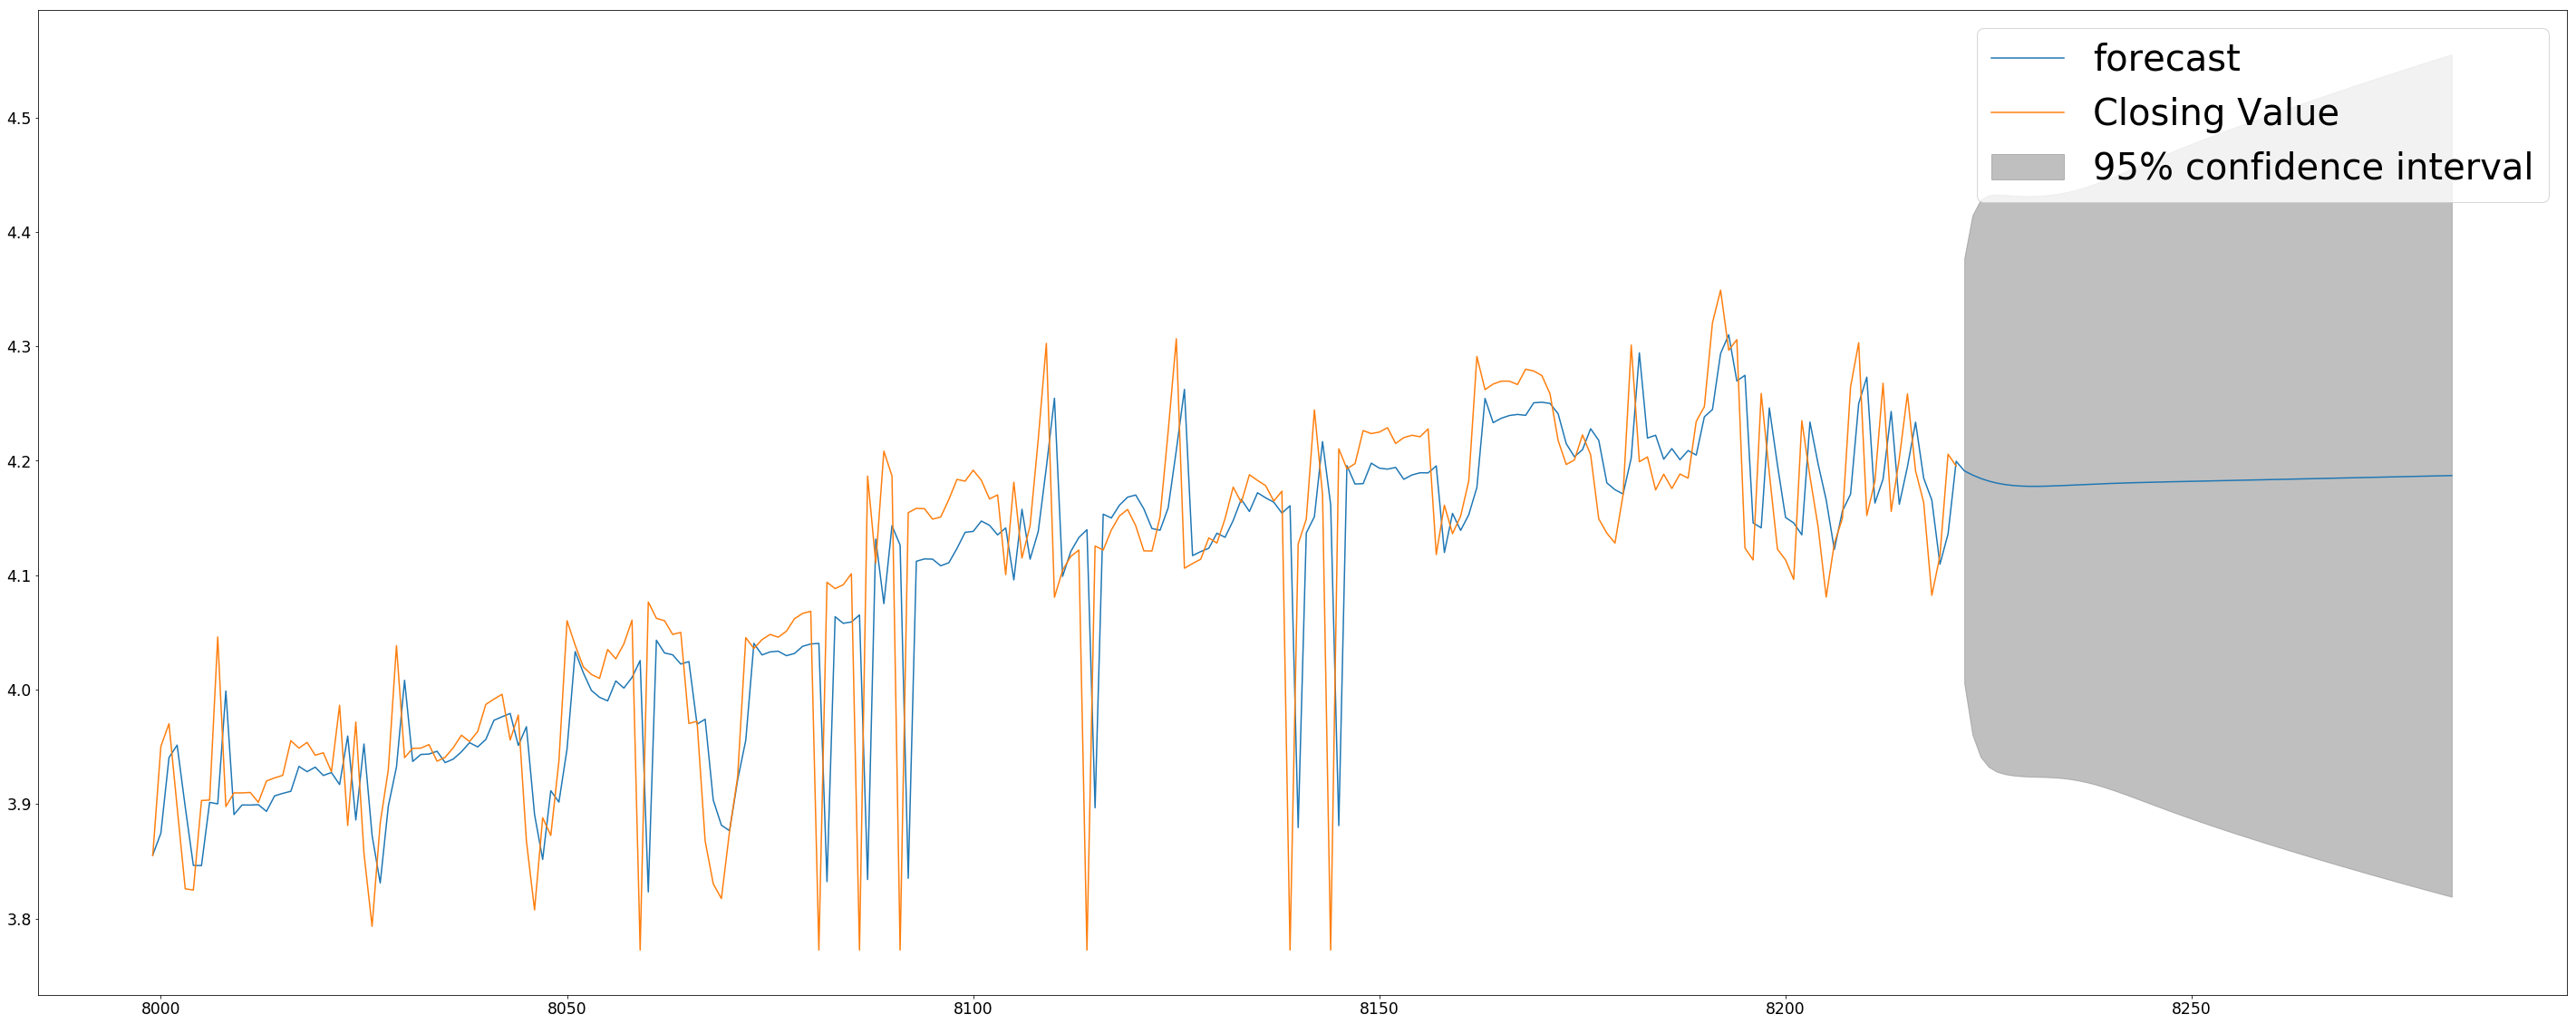

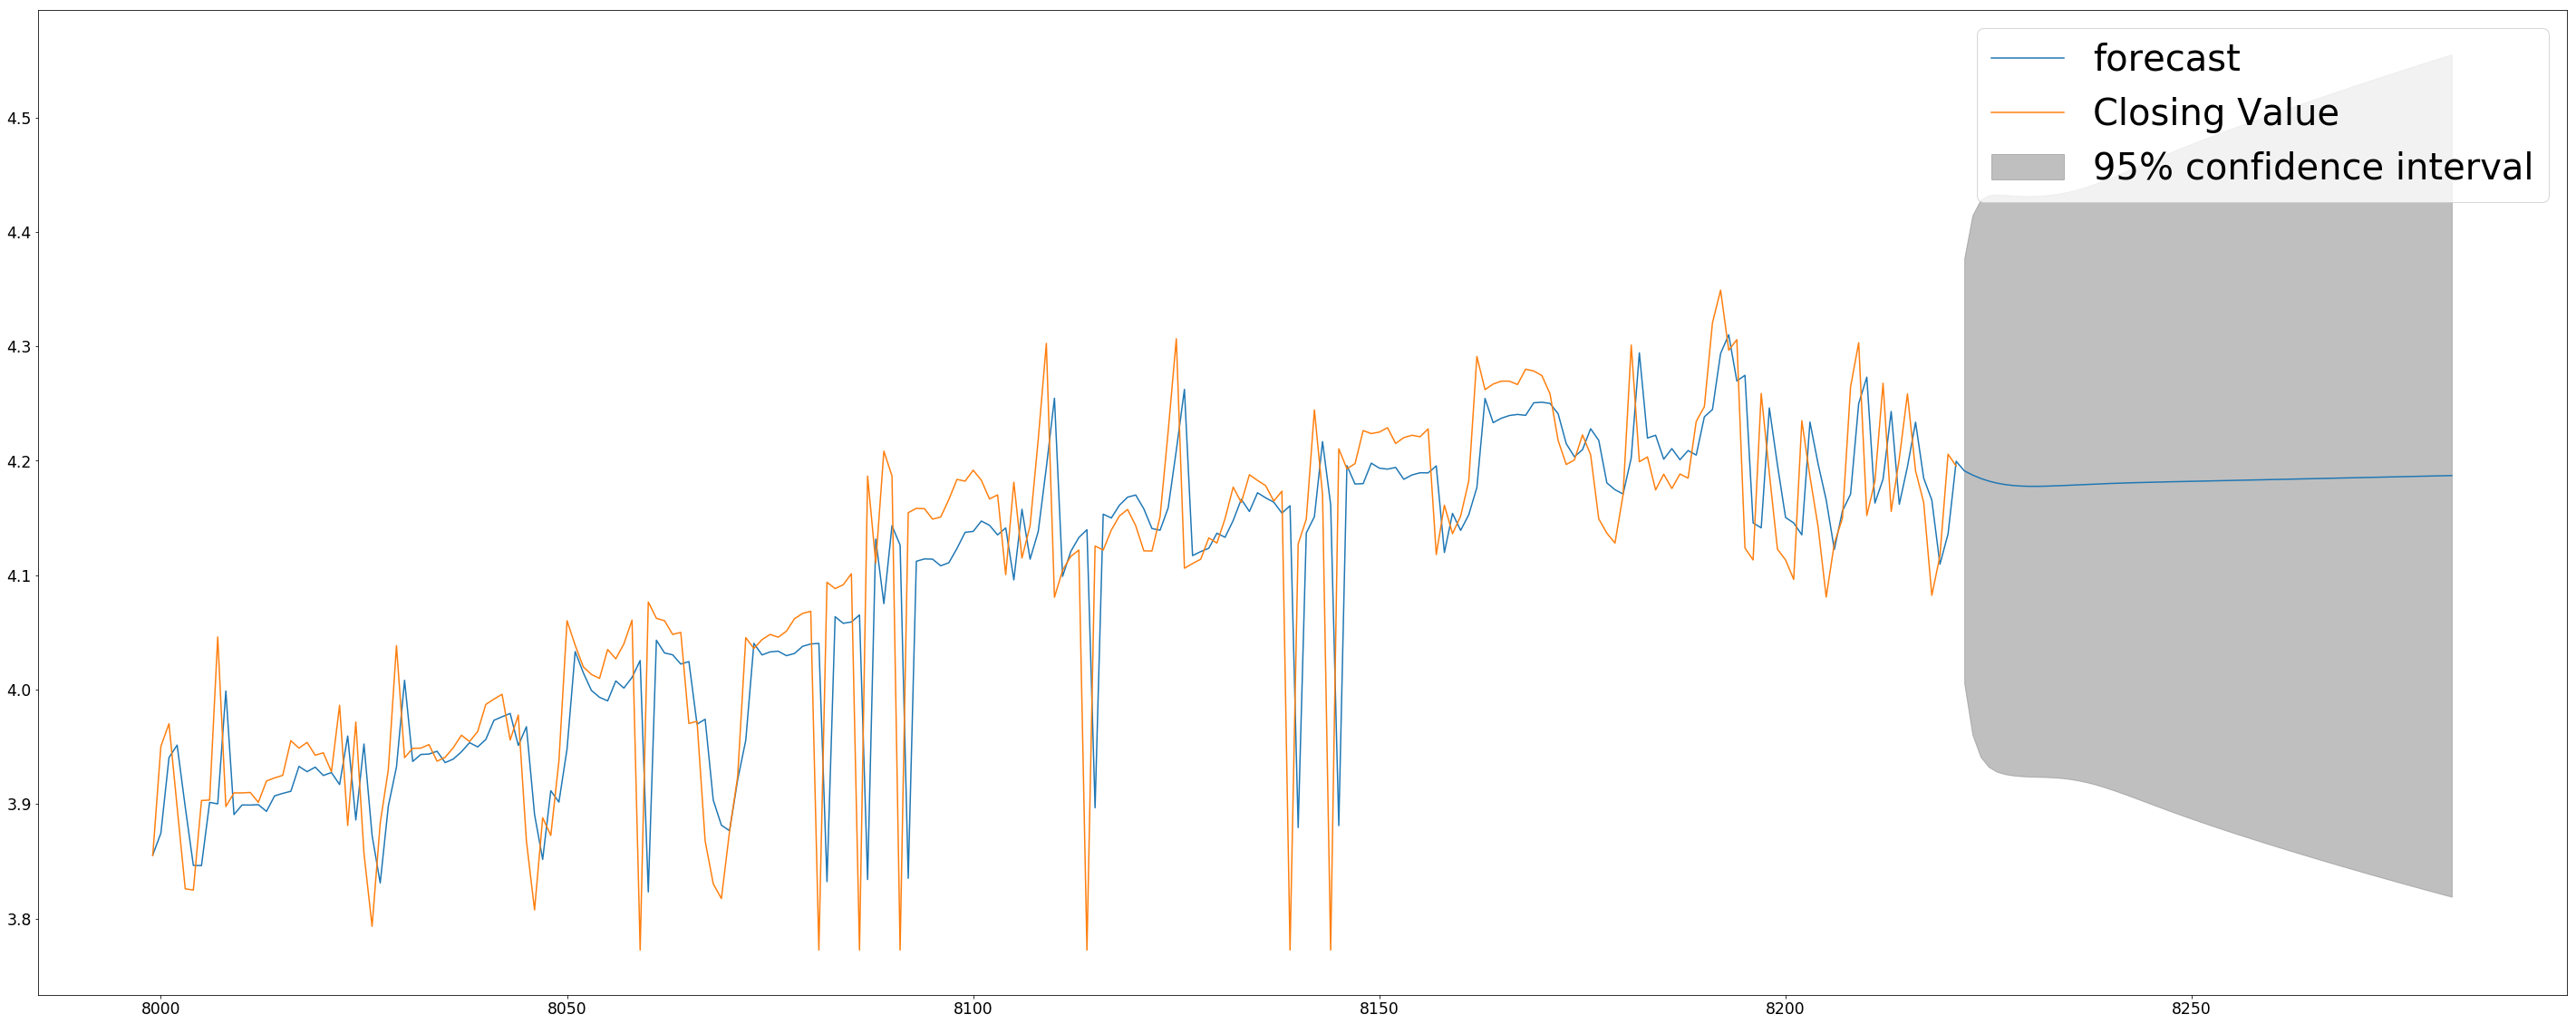

In [113]:
results_ARIMA.plot_predict(8000, 8283)